In [1]:
import scanpy as sc
#import gseapy as gs
import numpy as np
import scipy as sp
from scipy.stats import spearmanr, pearsonr

import pandas as pd

In [2]:
# Importing plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
from matplotlib import cm

In [3]:
# Scanpy settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

celltype = 'cd8'
master_dir = ''

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.4 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0


In [4]:
# Get the dictionary associating pathway names with metabolic classifications
classifications = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg-KEGGclassified.gmt', 
                              header=None, sep='\t')
classifications.index = classifications[0]
classifications = classifications.drop(columns=[0])
classifications.columns = ['classification']
classifications = classifications.to_dict()['classification']

In [5]:
adata_metab = sc.read_h5ad(master_dir + 'output/' + celltype + '-processed-analyzed-metab.h5ad')
adata = sc.read_h5ad(master_dir + 'output/' + celltype + '-processed-analyzed.h5ad')
adata_metab

AnnData object with n_obs × n_vars = 25966 × 1387
    obs: 'patient', 'ICU_status', 'IL6i_between_draws', 'no_IL6i', 'WHO_scale', 'Blood_draw_time', 'Sex', 'Age_at_baseline', 'Days_since_onset_of_symptoms', 'louvain', 'Days_since_onset_float', 'umap_density_ICU_status'
    uns: 'ICU_status_colors', 'louvain', 'louvain_colors', 'neighbors', 'patient_colors', 'pca', 'rank_genes_groups', 'umap', 'umap_density_ICU_status_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
# Loading in metabolics-relevant pathways from KEGG (based on Xiao et al. Nat Commun 2019)
#metab_pathway_list = pd.read_csv(master_dir + 'data/MSigDB/KEGG_metab_pathway_list_Xiao2019-JLmod200620.txt', 
#                                 sep='\t', header=None)
#metab_pathway_list = np.array(metab_pathway_list.iloc[:, 0])

# Genes in each KEGG pathway
metab_genes = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg.gmt', 
                          sep='\t', header=None)
metab_genes.index = metab_genes.iloc[:, 0]
metab_genes = metab_genes.drop([0], axis=1)
# Drop the following pathways because none of the genes are found in the preprocessed adata
metab_genes = metab_genes.drop(index=['C5-Branched dibasic acid metabolism',
                                     'Lysine biosynthesis', 
                                     'D-Arginine and D-ornithine metabolism',
                                     'Polyketide sugar unit biosynthesis', 
                                     'Biosynthesis of vancomycin group antibiotics', 
                                     'Penicillin and cephalosporin biosynthesis'])

metab_pathway_list = metab_genes.index
metab_genes.head()

1       2     3      4    \
0                                                                       
Glycolysis / Gluconeogenesis                LDHC     HK3  LDHB   PFKP   
Citrate cycle (TCA cycle)                   DLST    ACO1    CS  IDH3B   
Pentose phosphate pathway                   PFKP   ALDOA  RPIA  ALDOB   
Pentose and glucuronate interconversions  UGT2B4  UGT2A1  XYLB  CRYL1   
Fructose and mannose metabolism              HK3  PFKFB3  PFKP   FCSK   

                                              5       6      7        8    \
0                                                                           
Glycolysis / Gluconeogenesis                ALDOA   ALDOB   ADH6   GAPDHS   
Citrate cycle (TCA cycle)                    ACLY  SUCLG2   DLAT    IDH3A   
Pentose phosphate pathway                    H6PD     RPE  RPEL1  PRPS1L1   
Pentose and glucuronate interconversions  UGT2B17  UGT1A3   UGDH   UGT1A4   
Fructose and mannose metabolism             ALDOA   ALDOB   GFUS     TPI1   

                                             9     10   ...  124  125  126  \
0                                                       ...                  
Glycolysis / Gluconeogenesis                DLAT  PGM1  ...  NaN  NaN  NaN   
Citrate cycle (TCA cycle)                 SUCLA2  PDHB  ...  NaN  NaN  NaN   
Pentose phosphate pathway                   PFKM  RBKS  ...  NaN  NaN  NaN   
Pentose and glucuronate interconversions  UGT1A8  UGP2  ...  NaN  NaN  NaN   
Fructose and mannose metabolism             PMM2  SORD  ...  NaN  NaN  NaN   

                                          127  128  129  130  131  132  133  
0                                                                            
Glycolysis / Gluconeogenesis              NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Citrate cycle (TCA cycle)                 NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Pentose phosphate pathway                 NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Pentose and glucuronate interconversions  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Fructose and mannose metabolism           NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 133 columns]

In [7]:
# Convert the metabolic pathways dataframe into a dictionary for GSEA
metab_genes_dict = metab_genes.transpose().to_dict(orient='series')
for element in metab_genes_dict:
    # Only include the genes that are also found in the single cell sequencing
    metab_genes_dict[element] = list(set(metab_genes_dict[element]).intersection(set(adata.var_names)))
    #metab_genes_dict[element] = metab_genes_dict[element][metab_genes_dict[element] != 'nan']
#metab_genes_dict['Glycolysis / Glucogeneogenesis_test'] = ['ACSS1', 'GAPDH']

In [8]:
# Also get a flat array of metabolism-related genes
metab_gene_list = []
for geneset in metab_genes_dict.values():
    for gene in geneset:
        metab_gene_list.append(gene)
metab_gene_list = np.array(metab_gene_list)
len(metab_gene_list)

2385

# Pathway activity analysis 
Modeled after Xiao et al. <i>Nat Commun</i> (2019) Fig. 2

For the i-th metabolic gene, the <u>mean expression level</u> across cells of the j-th cell type is

$E_{i,j} = \frac{\sum_{k=1}^{n_j} g_{i,k}}{n_j}, i \in 1 ... M, j \in 1 ... N $

in which $n_j$ is the number of cells in the j-th cell type, $g_{i,k}$ is the expression level of the i-th gene in the k-th cell in this cell type, M is the number of metabolic genes, and N is the number of cell types.

<u>Relative expression level</u> of gene i in cell type j is

$r_{i,j} = \frac{E_{i,j}}{1/N \sum_j^N E_{i,j}}$

Exclude genes with low expression level or high dropout rate:

Exclude outliers in each pathway defined by genes with relative expression levels >3 x 75th percentile expression or <1/3 x 25th percentile

<u>Pathway activity score for the t-th pathway and the j-th cell type is the weighted average of $r_{i,j}$ over all genes included in this pathway:</u>

$p_{t,j} = \frac{\sum_{i=1}^{m_t} w_i \times r_{i,j}}{\sum_{i=1}^{m_t} w_i}$

where $m_t$ is the number of genes in the pathway t, $w_i$ is the weighting factor equal to the reciprocal of the number of pathways that include the i-th gene.

In [9]:
pathways = [list(genes) for genes in list(metab_genes_dict.values())]

# wi is the reciprocal of the number of pathways that include the ith gene,
# summarized in array w
w = [[pathway.count(gene) / list(metab_gene_list).count(gene) for gene 
      in adata_metab.var_names.values] for pathway in pathways]

In [10]:
# Here, cell type is defined as individual clusters ('louvain')
# within a given group of immune cells (B cells, T cells, etc.)
# Clusters calculated from all genes rather than just metabolic genes
# in order to associate the metabolic gene set enrichment with the non-metabolic analyses
def pathway_activity(data, data_metab, cluster_label, print_labels=False, nanval=0, exclude_clusters=[]):
    mel = []
    cluster_ids = list(data.obs[cluster_label].unique())
    cluster_ids.sort()
    for cluster_id in exclude_clusters:
        cluster_ids.remove(cluster_id)
    for cluster_id in cluster_ids:
        if print_labels:
            print(cluster_id)
        cluster = data_metab[data.obs[cluster_label]==cluster_id]
        g = cluster.X # Matrix of gene expression of ith gene in the kth cell of this cluster (cell type)
        n = len(cluster) # Number of cells in the cluster (cell type)
        # Calculate mean expression level
        mel.append(np.sum(g, axis=0) / n) # Sum gene expressions per gene across all cells in this cluster (cell type),
            # divided by number of cells in the cluster (cell type)        

    # Remove genes that are 0 in any cluster to avoid extreme ratio value
    mel = np.array(mel)
    m = min(mel[mel > 0])
    mel[mel==0] = m
            
    # Calculate relative expression level of each gene
    rel = mel / (np.sum(mel, axis=0) / len(mel))

    # Filtering
    lowExpr, highExpr = np.percentile(rel, [25, 75], axis=None) 
    
    tooHigh = (rel > 3 * highExpr) * rel
    tooLow = (rel < lowExpr / 3) * rel
    
    rel -= tooHigh
    rel -= tooLow
    rel = np.nan_to_num(rel, nan=nanval)
    
    # Calculate the pathway activity score
    # Pathway activity matrix
    # Each row is a pathway, each column is a cluster
    p = np.array([np.sum(w * rel[j], axis=1) / np.sum(w, axis=1) for j in range(len(rel))]).transpose()
    
    # Remove nan values
    p = np.nan_to_num(p, nan=1)
    
    return p

## Pathway activity analysis between clusters among all populations

In [11]:
p = pathway_activity(adata, adata_metab, 'louvain', print_labels=True)

0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


1
2
3
4
5
6
7
8
9


Calculate <u>statistical significance</u>: random permutation test
1. Randomly shuffle cell type labels 5,000 times to simulate null distribution of pathway activity scores
2. Compare to the pathway activity scores in the original, non-shuffled dataset
3. p-value = fraction of random pathway activity scores 
    - $> p_{t,j}$ if $p_{t,j} > 1$, meaning that pathway activity is significantly higher 
    - $< p_{t,j}$ if $p_{t,j} < 1$, meaning that pathway activity is significantly lower

In [12]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 1000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['louvain'])
    adata.obs['louvain_shuffle'] = clusters_shuffled
    adata_metab.obs['louvain_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'louvain_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


KeyboardInterrupt: 

In [13]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

In [14]:
# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)
# Read saved pathway activity scores
df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster-pathway_activity.tabular', 
                   sep='\t', header=None)
df_p.head()

0         1         2         3         4         5         6  \
0  1.000000  1.000000  0.758767  1.000000  0.335202  0.302048  0.848986   
1  0.879075  0.820157  0.764225  0.807739  0.266979  0.302467  0.803004   
2  0.951593  1.000000  0.788014  0.903242  0.271896  0.320762  0.857763   
3  0.884555  0.757981  0.613858  0.786291  0.183493  0.198029  0.675255   
4  0.801984  0.922712  0.735620  0.881174  0.452217  0.347253  0.792240   

          7         8         9  
0  0.525417  1.554526  1.175482  
1  0.588406  1.932783  1.217395  
2  0.461595  1.697069  1.309769  
3  0.371419  1.300898  1.000000  
4  0.628796  1.504673  1.000000

<ipython-input-15-e15126f9716d>:4: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0), row_cluster=False, figsize=(6, 10))


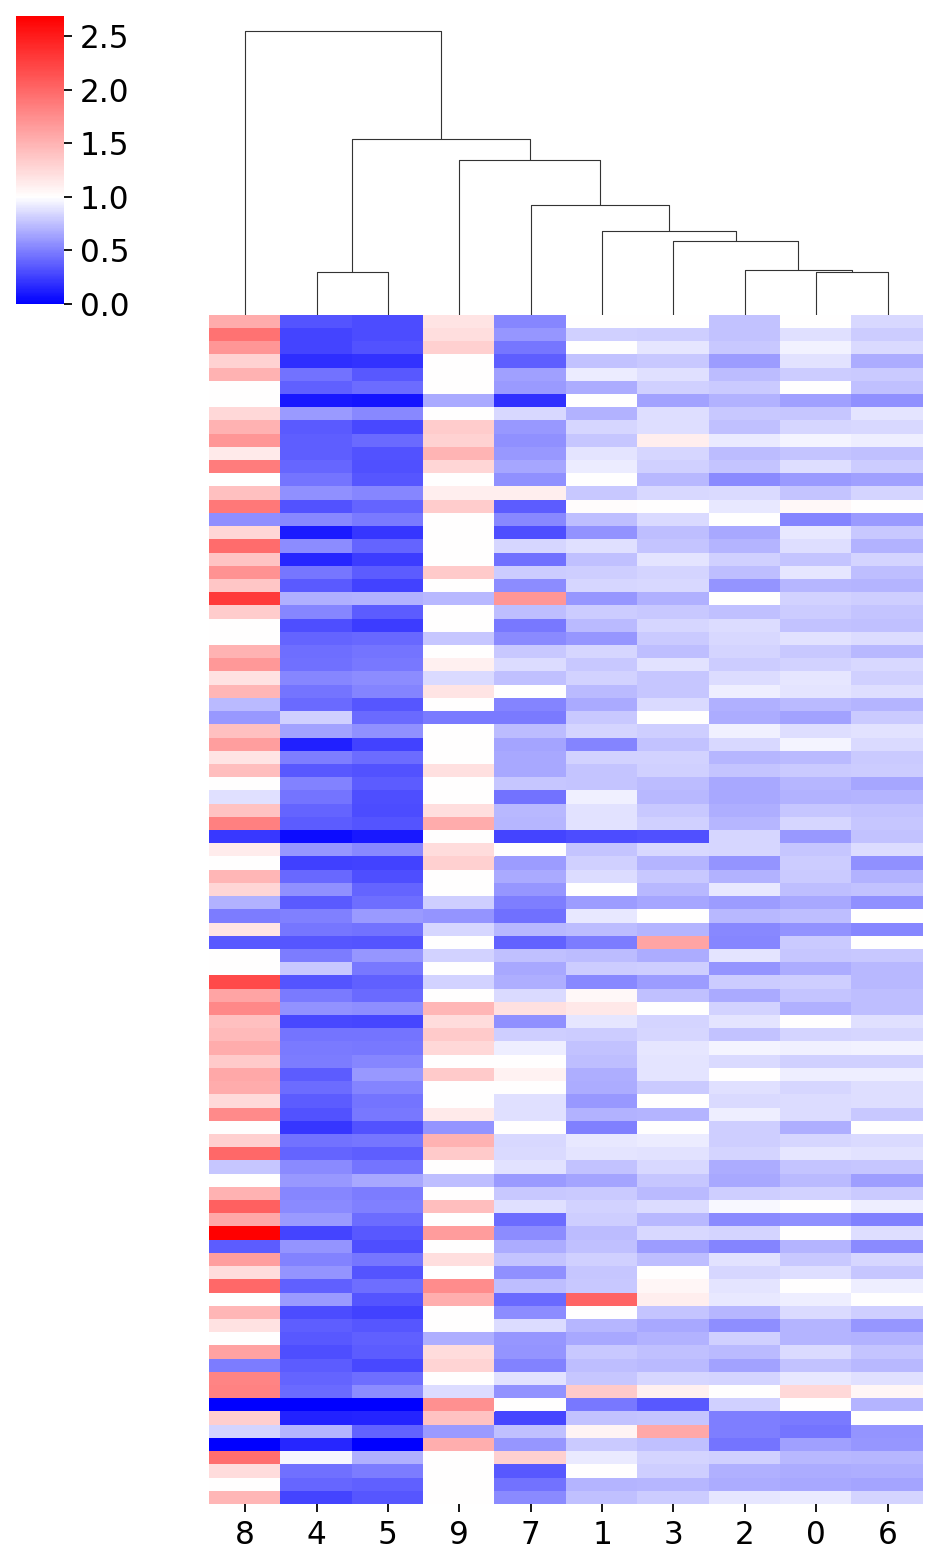

In [15]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
fig = sns.clustermap(df_p, cmap='bwr', yticklabels=[], #yticklabels=metab_genes.index, 
                     norm=DivergingNorm(1.0), row_cluster=False, figsize=(6, 10))

#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

### Metabolic clusters instead of overall clusters

In [11]:
adata.obs['louvain_metab'] = adata_metab.obs['louvain']

In [17]:
p = pathway_activity(adata, adata_metab, 'louvain_metab', print_labels=True)

0
1
2
3
4
5
6


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [18]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 1000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['louvain_metab'])
    adata.obs['louvain_metab_shuffle'] = clusters_shuffled
    adata_metab.obs['louvain_metab_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'louvain_metab_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

0
100


KeyboardInterrupt: 

In [ ]:
# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-metab_cluster-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)
# Read saved pathway activity scores
#df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-metab_cluster-pathway_activity.tabular', 
#                   sep='\t', header=None)
#df_p.head()

In [ ]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
#df_p = pd.DataFrame(p)
fig = sns.clustermap(df_p, cmap='coolwarm', yticklabels=[], #yticklabels=metab_genes.index, 
                     norm=DivergingNorm(1.0), row_cluster=False, figsize=(4, 10))

#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

Same as above, now excluding clusters 4 and 6

In [ ]:
p = pathway_activity(adata, adata_metab, 'louvain_metab', print_labels=True, exclude_clusters=['4', '6'])

In [ ]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 1000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['louvain_metab'])
    adata.obs['louvain_metab_shuffle'] = clusters_shuffled
    adata_metab.obs['louvain_metab_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'louvain_metab_shuffle', exclude_clusters=['4', '6'])
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

In [ ]:
# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-metab_cluster-0_1_2_3_5-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)
# Read saved pathway activity scores
#df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-metab_cluster-pathway_activity.tabular', 
#                   sep='\t', header=None)
#df_p.head()

In [ ]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
df_p = pd.DataFrame(p_sig)
fig = sns.clustermap(df_p, cmap='coolwarm', yticklabels=[], #yticklabels=metab_genes.index,
                     xticklabels=['0', '1', '2', '3', '5'],  
                     norm=DivergingNorm(1.0), row_cluster=False, figsize=(3, 10))

## Pathway activity based on treatment status


In [ ]:
adata.obs['no_IL6i_time'] = adata.obs['no_IL6i'].astype(str) + '.' + adata.obs['Blood_draw_time'].astype(str)

In [ ]:
# Here, cell type is defined as individual clusters ('louvain')
# within a given group of immune cells (B cells, T cells, etc.)
# Clusters calculated from all genes rather than just metabolic genes
# in order to associate the metabolic gene set enrichment with the non-metabolic analyses
p = pathway_activity(adata, adata_metab, 'no_IL6i_time', print_labels=True)

In [ ]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['no_IL6i_time'])
    adata.obs['no_IL6i_time_shuffle'] = clusters_shuffled
    adata_metab.obs['no_IL6i_time_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'no_IL6i_time_shuffle');
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant
#p_sig

In [ ]:
# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-no_IL6i-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

In [ ]:
# Heatmap of pathway activities
#fig = plt.figure(figsize=(15, 20))
p_sig_reorder = p_sig[:, [0, 2, 1, 3, 4]]
fig = sns.clustermap(p_sig_reorder, cmap='bwr', yticklabels=metab_genes.index, 
                     xticklabels=['Healthy', 'Before', 'After', 'No.T1', 'No.T2'], 
                     row_cluster=None, norm=DivergingNorm(1.0), figsize=(15, 20))
#fig.set_xticklabels(adata.obs['no_IL6i'].unique())
#fig.set_xlabel('Patient IL6i status')
#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

### Excluding the "before" and "no" states of IL6i treatment

In [ ]:
# Here, cell type is defined as individual clusters ('louvain')
# within a given group of immune cells (B cells, T cells, etc.)
# Clusters calculated from all genes rather than just metabolic genes
# in order to associate the metabolic gene set enrichment with the non-metabolic analyses
data = adata[adata.obs['no_IL6i'].isin(['Healthy', 'before'])].copy()
data_metab = adata_metab[adata_metab.obs['no_IL6i'].isin(['Healthy', 'before'])].copy()
p = pathway_activity(data, data_metab, 'no_IL6i', print_labels=True)

In [ ]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(data.obs['no_IL6i'])
    data.obs['no_IL6i_shuffle'] = clusters_shuffled
    data_metab.obs['no_IL6i_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(data, data_metab, 'no_IL6i_shuffle');
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant
#p_sig

In [ ]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
#fig = plt.figure(figsize=(15, 20))
fig = sns.clustermap(p, cmap='bwr', yticklabels=metab_genes.index, 
                     norm=DivergingNorm(1.0), figsize=(12, 20))
#fig.set_xticklabels(adata.obs['no_IL6i'].unique())
#fig.set_xlabel('Patient IL6i status')
#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

### Subset analysis (7/3/20)

In [ ]:
p = pathway_activity(adata, adata_metab, 'louvain', print_labels=True, exclude_clusters=['8', '9'])

In [ ]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
data = adata[adata.obs['louvain'] != '8']
data = data[data.obs['louvain'] != '9']

data_metab = adata_metab[data.obs['louvain'].index]

n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(data.obs['louvain'])
    data.obs['louvain_shuffle'] = clusters_shuffled
    data_metab.obs['louvain_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(data, data_metab, 'louvain_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

In [ ]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant

# Save pathway activity scores
#df_p = pd.DataFrame(p_sig)
#df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster_wo_8_9-pathway_activity.tabular', 
#                       sep='\t', header=None, index=None)

# Read previously saved file
df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster_wo_8_9-pathway_activity.tabular', 
                       sep='\t', header=None)
df_p.head()

In [ ]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
fig = sns.clustermap(df_p, cmap='bwr', yticklabels=[], #metab_genes.index, 
                     row_cluster=False, norm=DivergingNorm(1.0), figsize=(6, 10))
#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

In [ ]:
# Now without clusters 4, 5, 8, 9
p = pathway_activity(adata, adata_metab, 'louvain', print_labels=True, exclude_clusters=['4', '5', '8', '9'],
                    nanval=1)

In [ ]:
p_healthy = pathway_activity(adata[adata.obs['WHO_scale']==0], 
                            adata_metab[adata.obs['WHO_scale']==0], 'louvain', 
                             print_labels=True, exclude_clusters=['4', '5', '8', '9'],
                            nanval=1)

In [ ]:
p_nonICU = pathway_activity(adata[adata.obs['ICU_status']=='Non-ICU'], 
                            adata_metab[adata.obs['ICU_status']=='Non-ICU'], 'louvain', 
                             print_labels=True, exclude_clusters=['4', '5', '8', '9'],
                            nanval=1)

In [ ]:
p_ICU = pathway_activity(adata[adata.obs['ICU_status']=='ICU'], 
                            adata_metab[adata.obs['ICU_status']=='ICU'], 'louvain', 
                             print_labels=True, exclude_clusters=['4', '5', '8', '9'],
                            nanval=1)

In [ ]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
data = adata[adata.obs['louvain'].isin(['0', '1', '2', '3', '6', '7'])]

data_metab = adata_metab[data.obs['louvain'].index]

n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(data.obs['louvain'])
    data.obs['louvain_shuffle'] = clusters_shuffled
    data_metab.obs['louvain_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(data, data_metab, 'louvain_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

In [ ]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant
#p_sig

# Save pathway activity scores
#df_p = pd.DataFrame(p_sig)
#df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
#                       sep='\t', header=None, index=None)
df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
                       sep='\t', header=None)
df_p.head()

In [ ]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
fig = sns.clustermap(df_p, cmap='bwr', yticklabels=[], #metab_genes.index, 
                     row_cluster=False,
                     xticklabels=['0', '1', '2', '3', '6', '7'], 
                     norm=DivergingNorm(1.0), figsize=(4, 10))
#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

In [ ]:
fig = sns.clustermap(p_healthy, cmap='bwr', yticklabels=metab_genes.index, row_cluster=False,
                     xticklabels=['0', '1', '2', '3', '6', '7'], figsize=(11, 20),
                     norm=DivergingNorm(1.0))

In [ ]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant
#p_sig

# Save pathway activity scores
df_p = pd.DataFrame(p_healthy)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-healthy-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

In [ ]:
fig = sns.clustermap(p_nonICU, cmap='bwr', yticklabels=metab_genes.index, row_cluster=False,
                     xticklabels=['0', '1', '2', '3', '6', '7'], figsize=(11, 20),
                     norm=DivergingNorm(1.0))

In [ ]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant
#p_sig

# Save pathway activity scores
df_p = pd.DataFrame(p_nonICU)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-nonICU-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

In [ ]:
fig = sns.clustermap(p_ICU, cmap='bwr', yticklabels=metab_genes.index, row_cluster=False,
                     xticklabels=['0', '1', '2', '3', '6', '7'], figsize=(11, 20),
                     norm=DivergingNorm(1.0))

In [ ]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant
#p_sig

# Save pathway activity scores
df_p = pd.DataFrame(p_ICU)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-ICU-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

### Analysis per patient

#### All cells

In [11]:
# Not using subpopulations here for now
p = pathway_activity(adata, adata_metab, 'patient', print_labels=True)

1-1
1-2
10-1
10-2
11-1
11-2
12-1
12-2
13-1
13-2
14-1
15-1
15-2
16-1
16-2
17-1
17-2
19-1
19-2
2-1
2-2
20-1
20-2
22-1
22-2
23-1
23-2
24-1
24-2
25-1
25-2
3-1
3-2
31-1
31-2
33-1
33-2
36-1
36-2
4-1
4-2
5-1
5-2
6-1
6-2
7-1
7-2
8-1
9-1
9-2
BP0219101
BP0319250
BP05191345
BP08191115
CL2
Mix_donor1


<ipython-input-12-81e7583dbf10>:16: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


Text(0.5, 91.5746527777778, '')

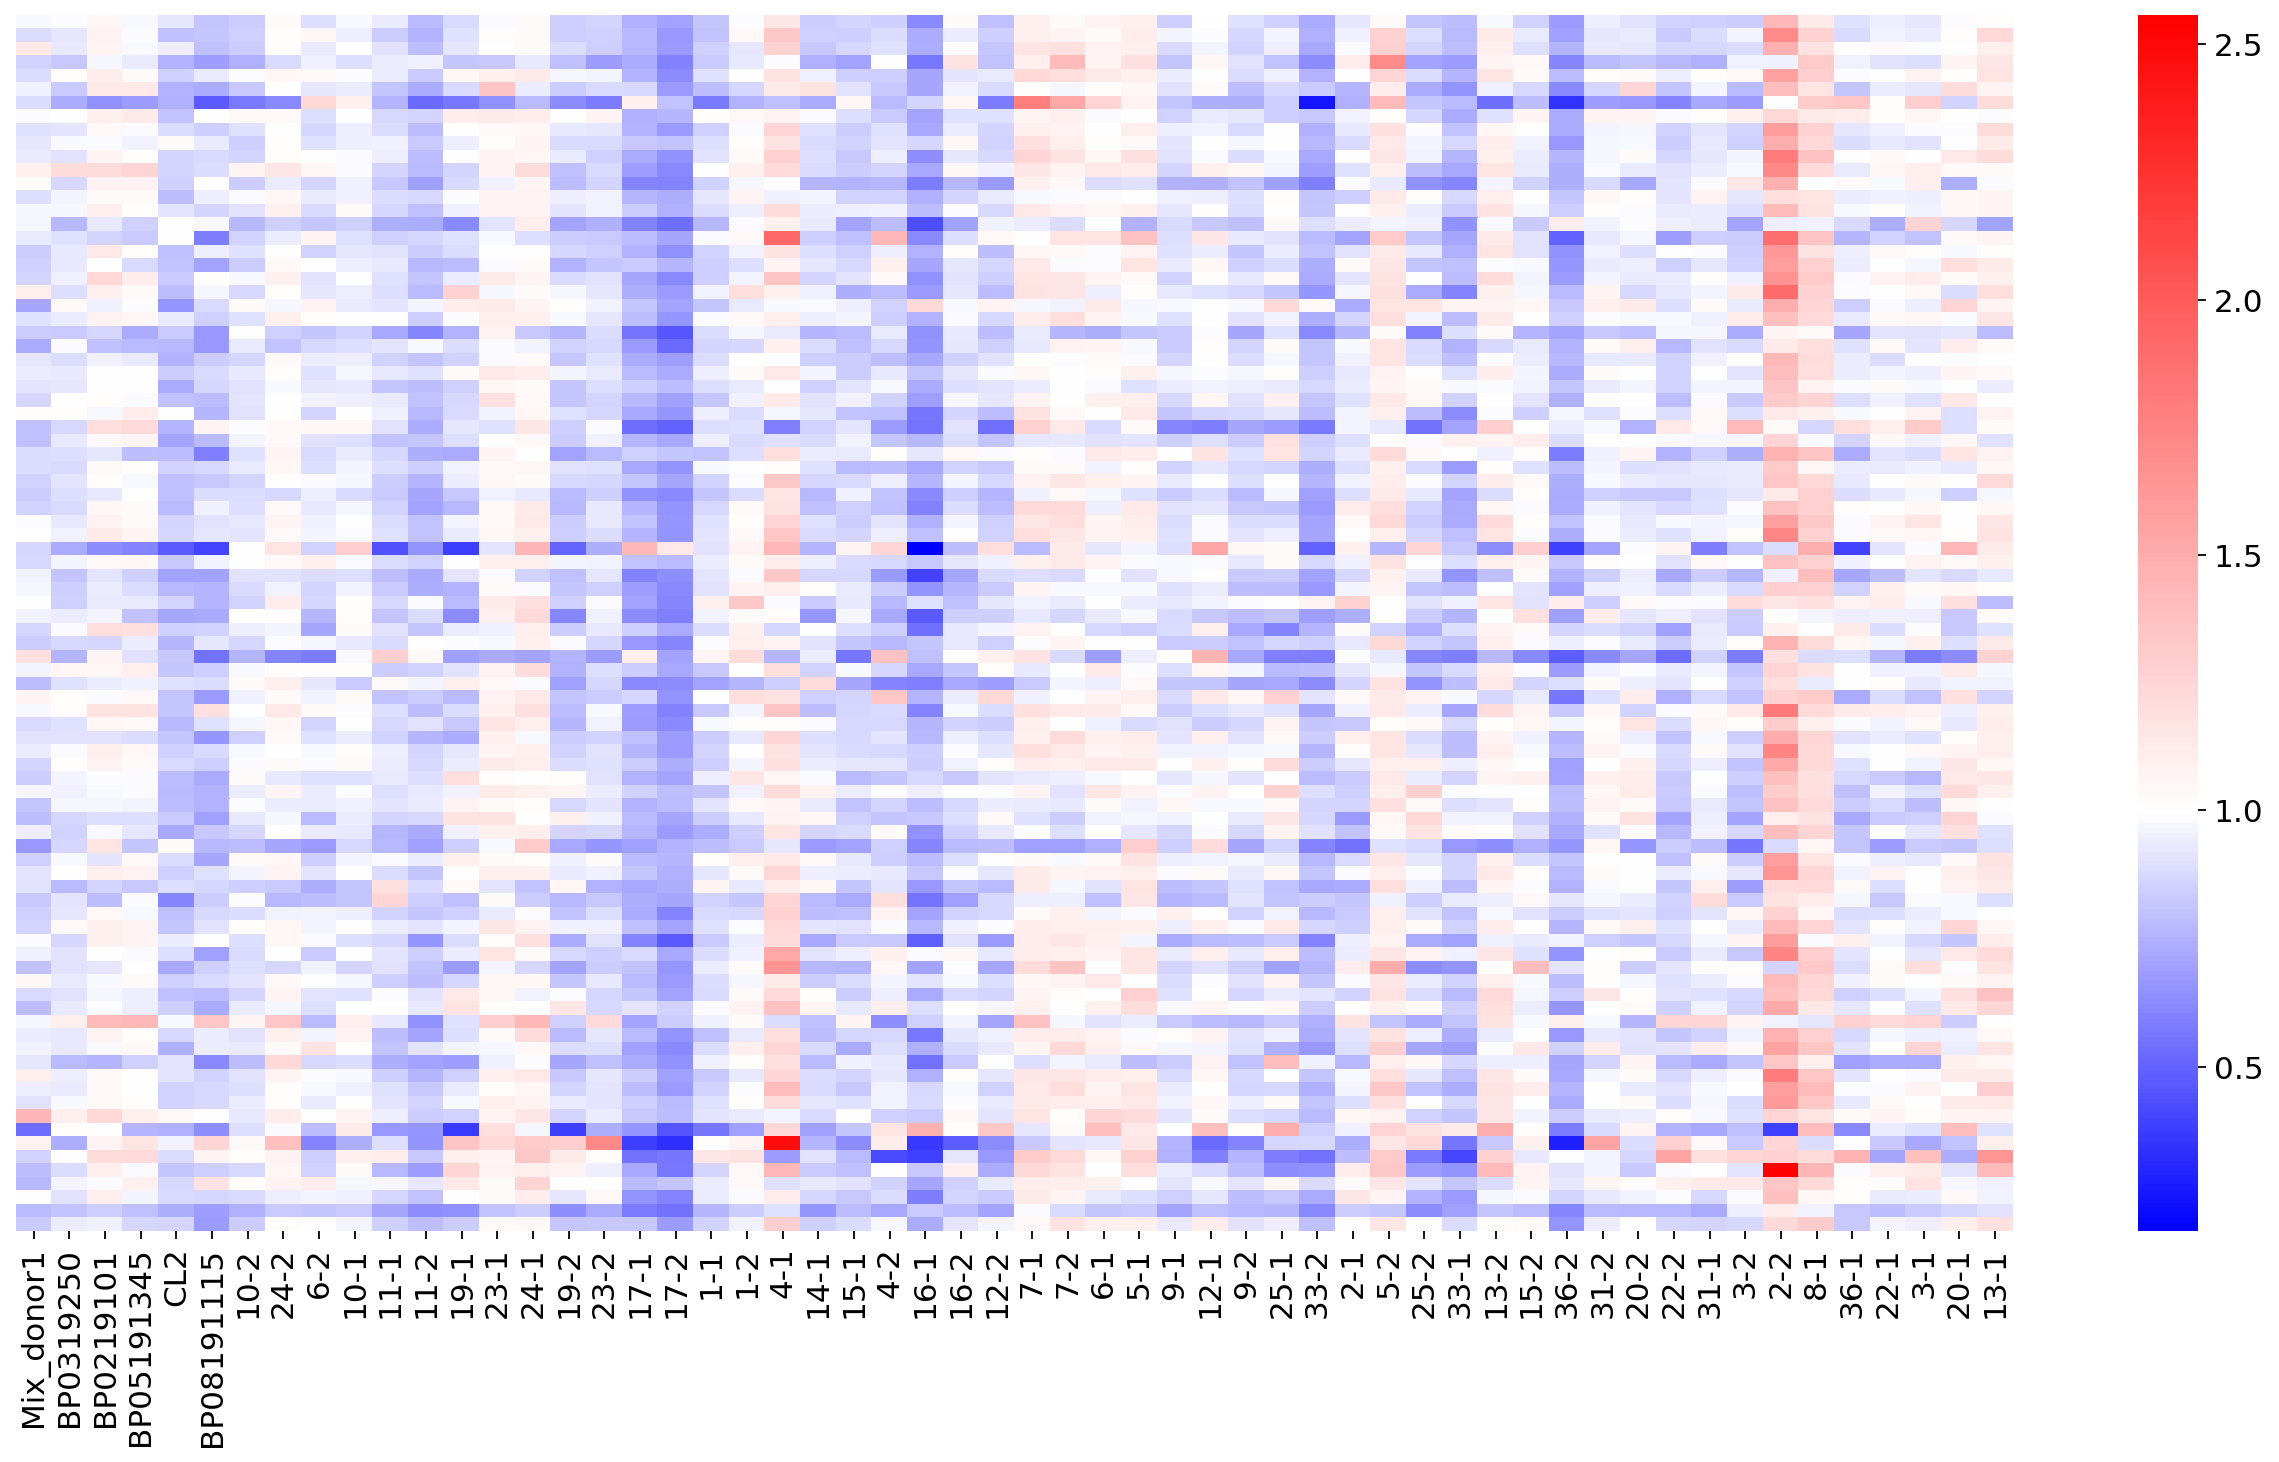

In [12]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 10))
ax = sns.heatmap(df_p, cmap='bwr', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

In [21]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x

n = 1000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['patient'])
    adata.obs['patient_shuffled'] = clusters_shuffled
    adata_metab.obs['patient_shuffled'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'patient_shuffled')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-patient-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

0
100
200
300
400
500
600
700
800
900


<ipython-input-13-91ca44599bb3>:20: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


Text(0.5, 67.5746527777778, '')

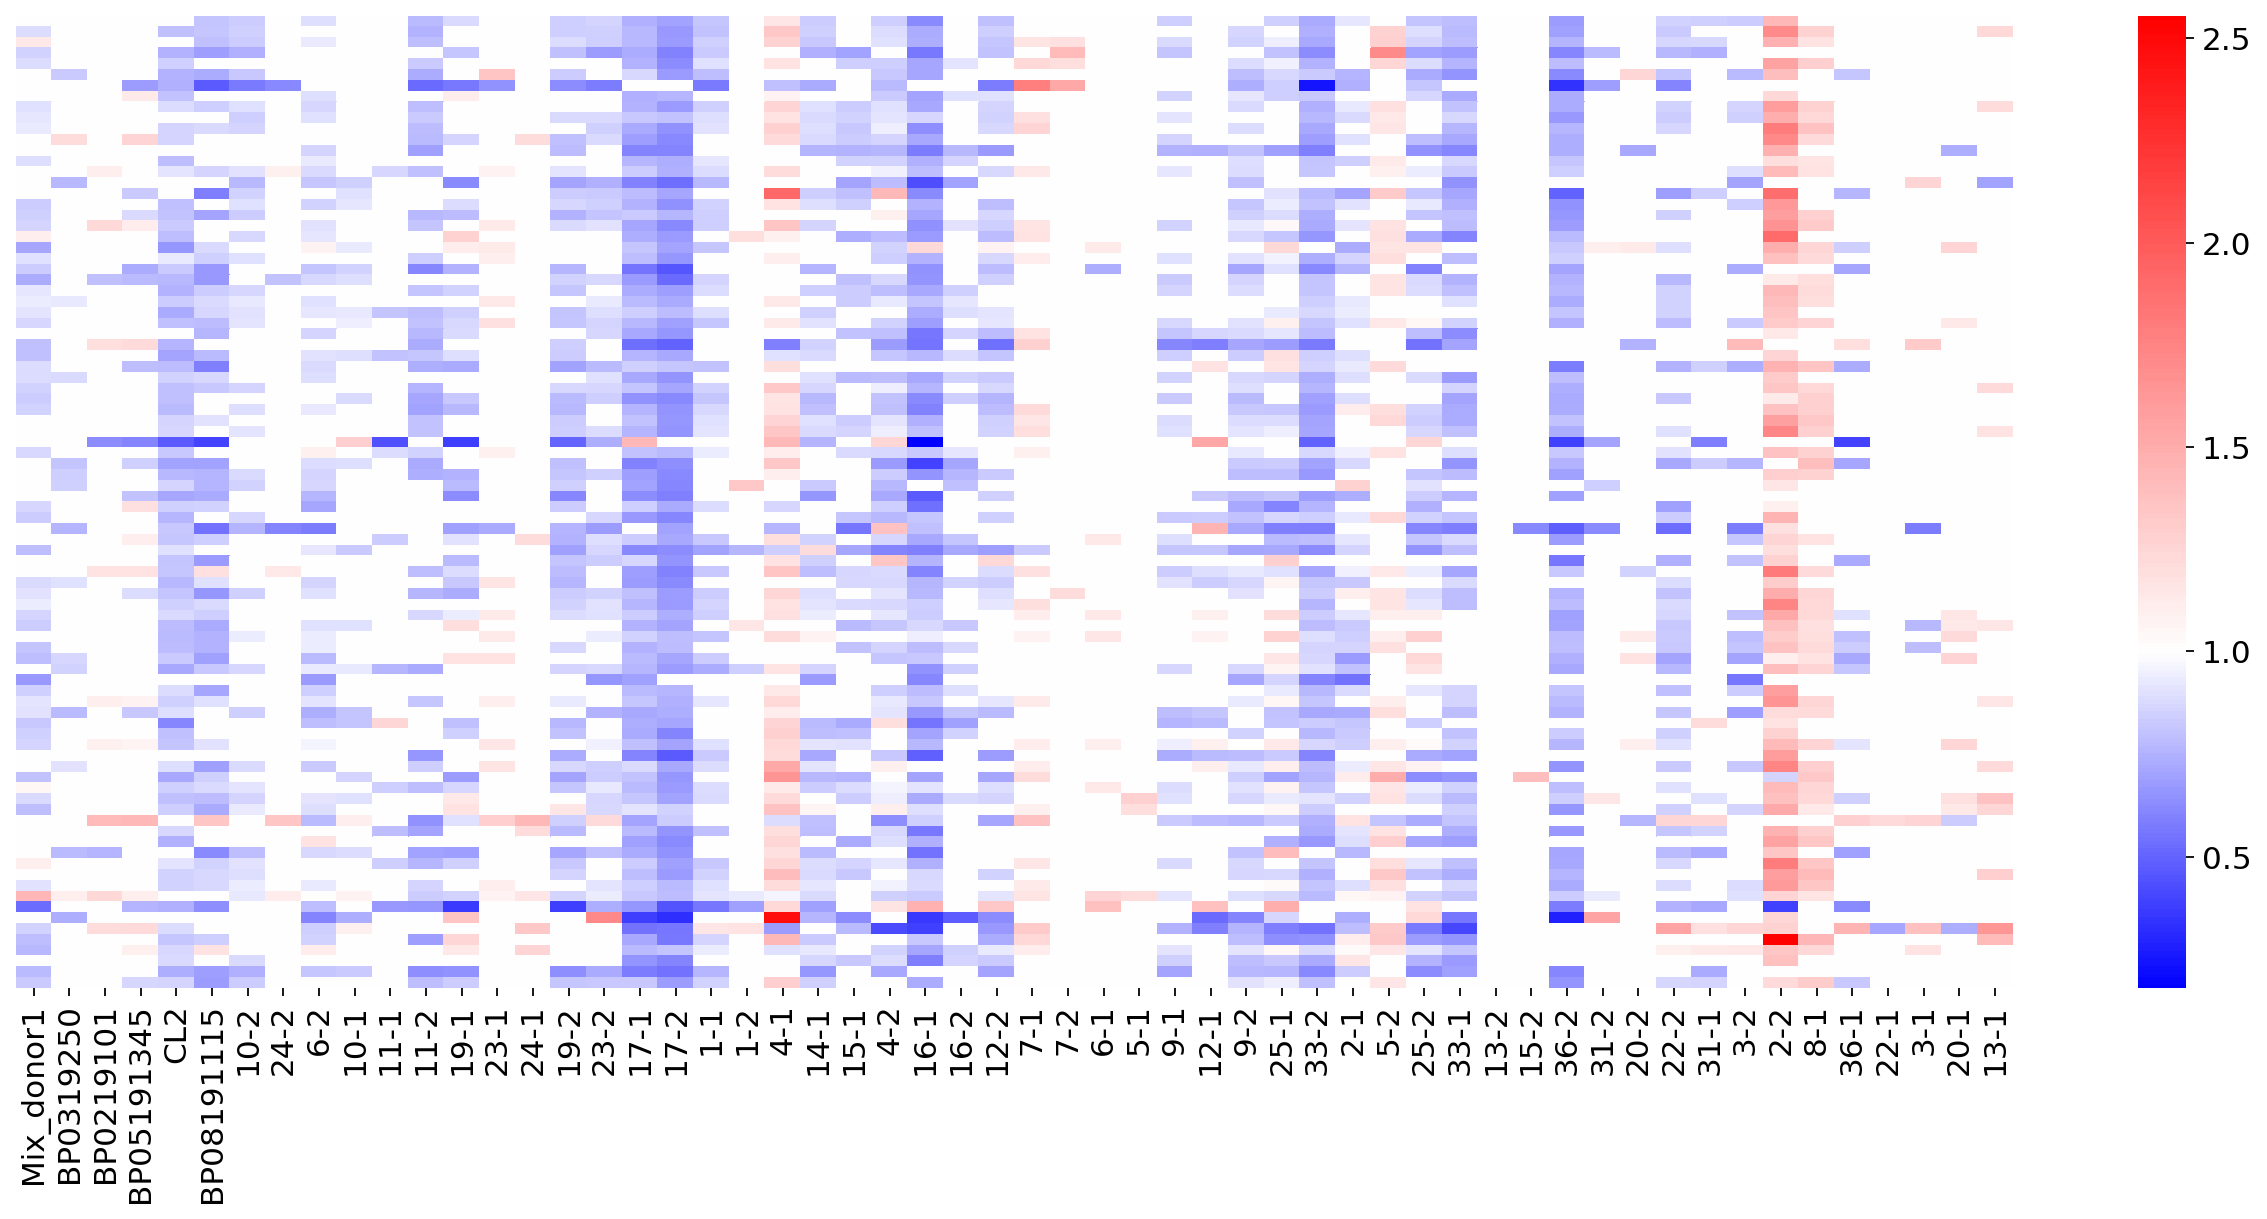

In [13]:
df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-patient-pathway_activity.tabular', 
                       sep='\t', header=None)

#df_p = pd.DataFrame(p_sig)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 8))
ax = sns.heatmap(df_p, cmap='bwr', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

<Figure size 320x320 with 0 Axes>

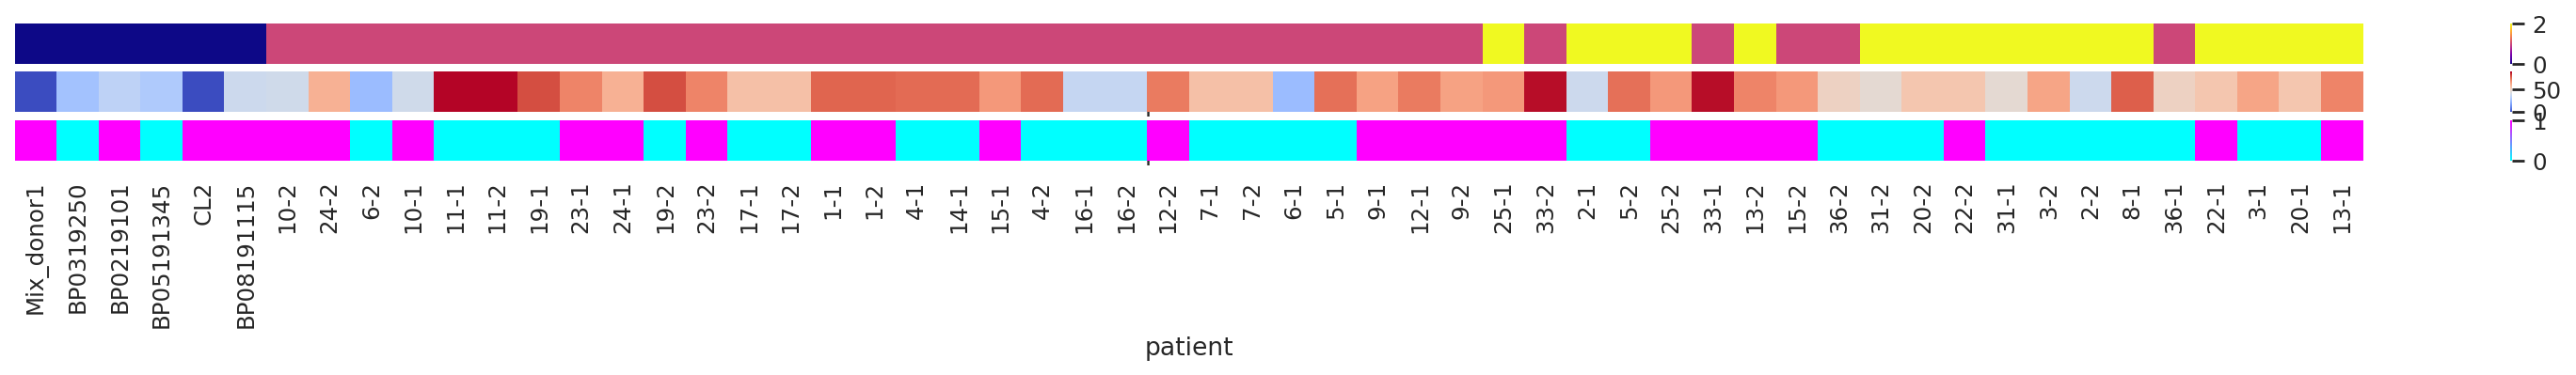

<Figure size 1280x24 with 0 Axes>

<Figure size 1280x24 with 0 Axes>

<Figure size 1280x24 with 0 Axes>

In [14]:
# Other patient attributes
adata_obs_by_patient = adata.obs.copy()
adata_obs_by_patient.index = adata_obs_by_patient['patient']
#adata_obs_by_patient.groupby(by='patient').first()
adata_obs_by_patient = adata_obs_by_patient.reset_index(drop=True)
adata_obs_by_patient = adata_obs_by_patient.groupby(by='patient').first() # All characteristics except clustering should be the same
adata_obs_by_patient['WHO_scale'] = adata_obs_by_patient['WHO_scale'].astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].str.replace('Not Recorded', 
                                                                                              '0').astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].astype(int)

# Plotting the other patient attributes
sns.set(style='white')
#sns.set(style='ticks')
sns.despine()

f, axes = plt.subplots(3, 1, figsize=(25, 1.2), sharex=False, sharey=False)

#df = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
#fig = plt.figure(figsize=(16, 0.3))
#fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
#                 cmap='Oranges', ax=axes[0])

df = adata_obs_by_patient.loc[patients_WHO, ['ICU_status']]
df['ICU_status'] = df['ICU_status'].map({'Healthy': 0, 'Non-ICU': 1, 'ICU': 2}).astype(int)
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
                 cmap='plasma', ax=axes[0])

#df = adata_obs_by_patient.loc[patients_WHO, ['no_IL6i']]
#df['no_IL6i'] = df['no_IL6i'].map({'Healthy': 0, 'before': 1, 'after': 2, 'no': 3}).astype(int)
#fig = plt.figure(figsize=(16, 0.3))
#fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
#                 cmap='viridis', ax=axes[2])

df = adata_obs_by_patient.loc[patients_WHO, ['Age_at_baseline']]
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''], vmin=0,
                 cmap='coolwarm', ax=axes[1])

df = adata_obs_by_patient.loc[patients_WHO, ['Sex']]
df['Sex'] = df['Sex'].map({'Female': 1, 'Male': 0}).astype(int)
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=patients_WHO, yticklabels=[''],
                 cmap='cool', ax=axes[2])

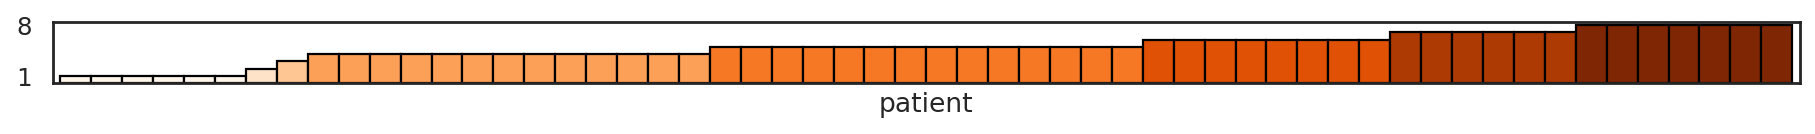

In [15]:
df = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
df['WHO_scale'] += 1 # Add 1 to all values in order to make all bars visible
fig = plt.figure(figsize=(14, 0.5))
oranges = cm.get_cmap('Oranges', 8)
df['c'] = [oranges(s - 1) for s in df['WHO_scale']]
fig = df['WHO_scale'].plot(kind='bar', color=df['c'], edgecolor='black', width=1)
#fig = plt.bar(x=df.index, height=df['WHO_scale'] + 1, color='brown')
                  #cmap='Oranges')
fig = plt.yticks([1, 8])
fig = plt.xticks([])

In [16]:
# For correlation, not using the statistically deleted values (need raw values)
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[0], 
                      axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[1], 
                         axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways['-log10(p)'] = -np.log10(sig_pathways['p-value'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
#pd.DataFrame(sig_pathways).to_csv(master_dir + 'output/pathway_activity/pathway_activity_trends/' + 
#                                 celltype + '-all_cells' + '.csv')
sig_pathways

Spearman   p-value  \
0                                                                        
Steroid hormone biosynthesis                        0.437947  0.000736   
Ether lipid metabolism                              0.387810  0.003145   
Glycosphingolipid biosynthesis - globo and isog...  0.365194  0.005649   
Histidine metabolism                                0.362550  0.006033   
Pyrimidine metabolism                               0.357713  0.006795   
alpha-Linolenic acid metabolism                     0.355452  0.007180   
Glutathione metabolism                              0.354338  0.007376   
Cutin, suberine and wax biosynthesis                0.336872  0.011125   
Drug metabolism - other enzymes                     0.335724  0.011421   
Biosynthesis of unsaturated fatty acids             0.333567  0.011995   
Fatty acid elongation                               0.319753  0.016293   
Vitamin B6 metabolism                               0.315265  0.017947   
Arginine and proline metabolism                     0.307402  0.021188   
D-Glutamine and D-glutamate metabolism              0.298181  0.025608   
Tryptophan metabolism                               0.293519  0.028123   
Ascorbate and aldarate metabolism                   0.289031  0.030737   
Nicotinate and nicotinamide metabolism              0.288787  0.030884   
Riboflavin metabolism                               0.288578  0.031011   
Glycosaminoglycan biosynthesis - heparan sulfat...  0.288091  0.031308   
Glycerolipid metabolism                             0.274035  0.040979   
Glycosphingolipid biosynthesis - lacto and neol...  0.273304  0.041543   
Ubiquinone and other terpenoid-quinone biosynth...  0.268885  0.045087   
Mannose type O-glycan biosynthesis                  0.265580  0.047898   

                                                    Spearman_abs  -log10(p)  
0                                                                            
Steroid hormone biosynthesis                            0.437947   3.132838  
Ether lipid metabolism                                  0.387810   2.502338  
Glycosphingolipid biosynthesis - globo and isog...      0.365194   2.248063  
Histidine metabolism                                    0.362550   2.219471  
Pyrimidine metabolism                                   0.357713   2.167780  
alpha-Linolenic acid metabolism                         0.355452   2.143871  
Glutathione metabolism                                  0.354338   2.132163  
Cutin, suberine and wax biosynthesis                    0.336872   1.953692  
Drug metabolism - other enzymes                         0.335724   1.942297  
Biosynthesis of unsaturated fatty acids                 0.333567   1.921000  
Fatty acid elongation                                   0.319753   1.788000  
Vitamin B6 metabolism                                   0.315265   1.746020  
Arginine and proline metabolism                         0.307402   1.673903  
D-Glutamine and D-glutamate metabolism                  0.298181   1.591621  
Tryptophan metabolism                                   0.293519   1.550936  
Ascorbate and aldarate metabolism                       0.289031   1.512345  
Nicotinate and nicotinamide metabolism                  0.288787   1.510267  
Riboflavin metabolism                                   0.288578   1.508487  
Glycosaminoglycan biosynthesis - heparan sulfat...      0.288091   1.504339  
Glycerolipid metabolism                                 0.274035   1.387436  
Glycosphingolipid biosynthesis - lacto and neol...      0.273304   1.381506  
Ubiquinone and other terpenoid-quinone biosynth...      0.268885   1.345946  
Mannose type O-glycan biosynthesis                      0.265580   1.319686

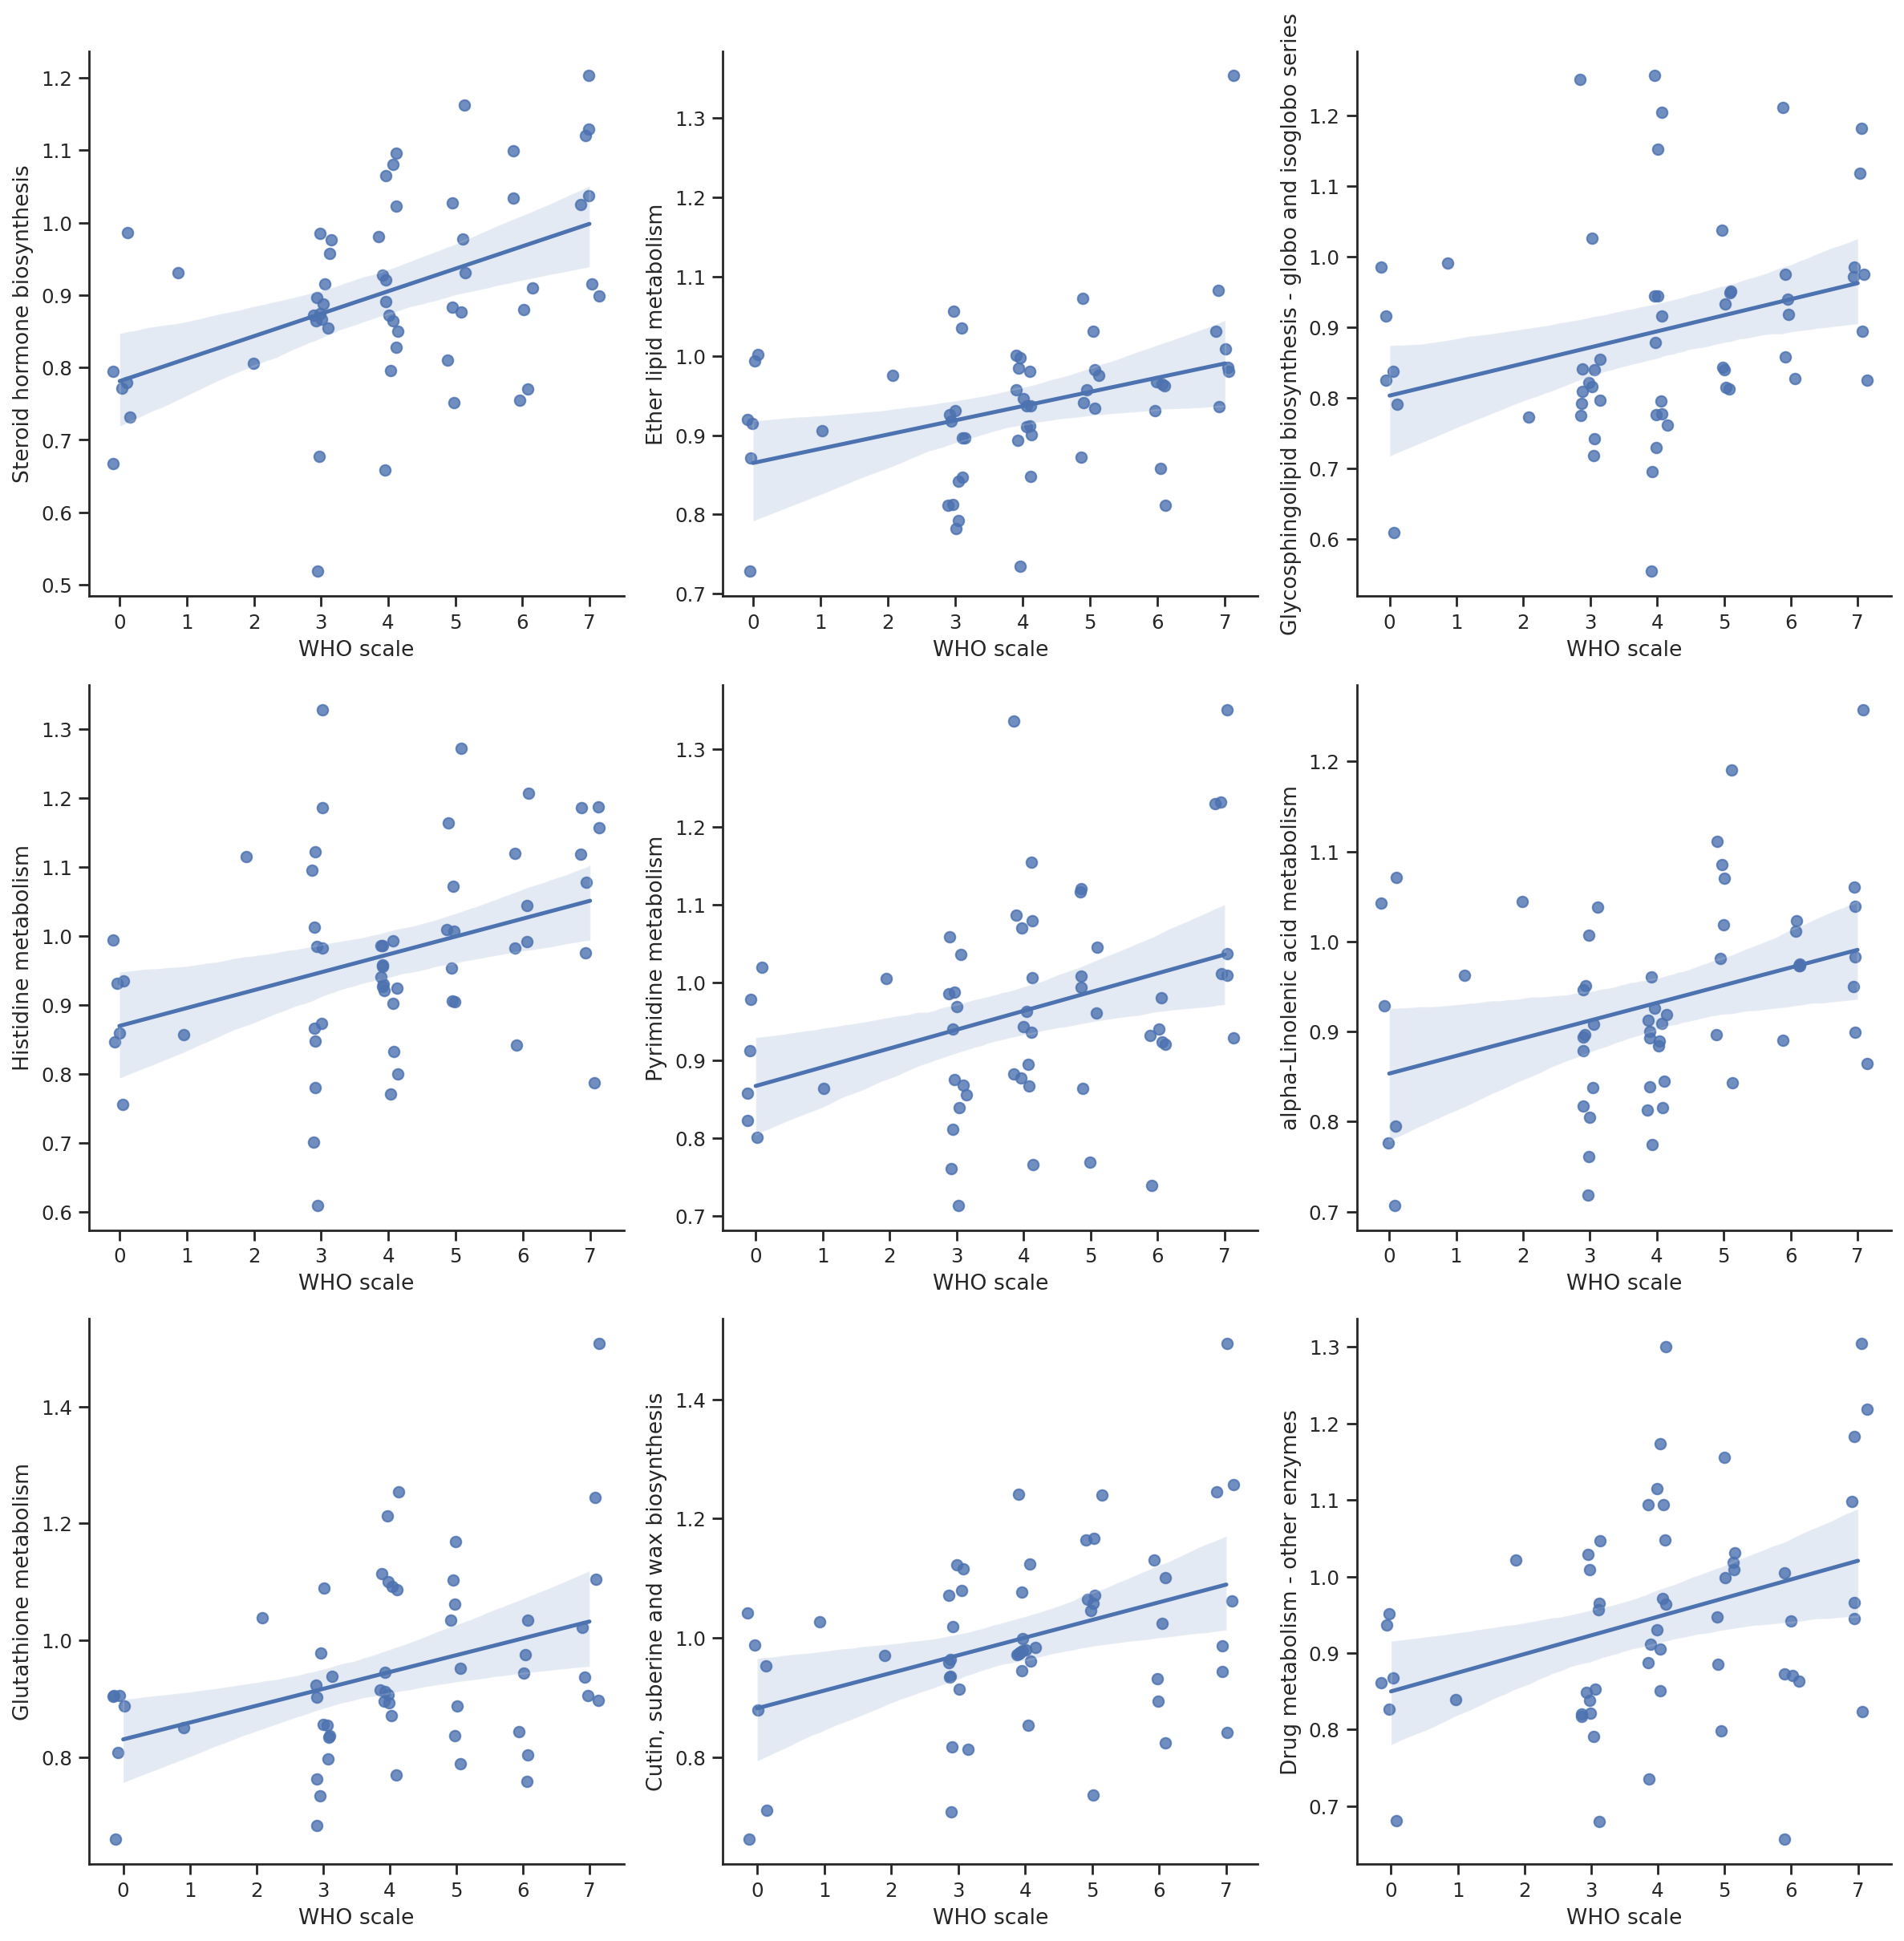

In [17]:
# Plot the top corresponding ones
sns.set_style('white')
sns.set_style('ticks')
f, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=False)
sns.despine()

k = 0
x = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
for i in range(3):
    for j in range(3):
        f = sns.regplot(x=x, y=df_p.loc[sig_pathways.index[k]], x_jitter=0.15, ax=axes[i, j])
        f.set_ylabel(sig_pathways.index[k])
        f.set_xlabel('WHO scale')
        f.set_xticks(range(8))
        k += 1

plt.tight_layout()

#### Correlating pathway activity plotting functions

In [12]:
def plot_corresponding(df_all, sig_pathways, orig_adata, figsize=(15, 3), cmap='coolwarm'):
    # Plot the top corresponding ones
    df_p_corresponding = pd.DataFrame(df_all)
    df_p_corresponding.index = metab_genes.index
    patients = adata.obs['patient'].unique().astype(str)
    patients.sort()
    df_p_corresponding.columns = patients

    patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
    #patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
    #patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
    #patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
    df_p_corresponding = df_p_corresponding.loc[sig_pathways.index, patients_WHO]

    # When plotting, sort by metabolic pathway group first, then by spearman r
    df_p_corresponding['category'] = df_p_corresponding.index.map(classifications)
    df_p_corresponding['Spearman'] = sig_pathways['Spearman']
    df_p_corresponding = df_p_corresponding.sort_values(by=['category', 'Spearman'], ascending=[True, False])
    print(df_p_corresponding['category'])
    df_p_corresponding = df_p_corresponding.drop(columns=['category', 'Spearman'])

    ax = plt.figure(figsize=figsize)
    ax = sns.heatmap(df_p_corresponding, cmap=cmap, yticklabels=[], vmin=0,
                         norm=DivergingNorm(1.0))
    #ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    return df_p_corresponding

def plot_spearman_dots(sig_pathways, df_corresponding, figsize=(5, 3)):
    # Dot plot for the significant ones
    sns.set_style('white')
    sns.set_style('ticks')
    fig = plt.figure(figsize=figsize)
    fig = sns.scatterplot(x=np.zeros(len(sig_pathways)), y=np.arange(0, len(sig_pathways), 1)[::-1], 
                          hue='Spearman', size='-log10(p)', hue_order=np.arange(0, 0.5, 0.1), 
                          sizes=(10, 40), data=sig_pathways.loc[df_corresponding.index])
    fig.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize=6)
    sns.despine()

0
Histidine metabolism                                                           Amino acid metabolism
Arginine and proline metabolism                                                Amino acid metabolism
Tryptophan metabolism                                                          Amino acid metabolism
Ascorbate and aldarate metabolism                                            Carbohydrate metabolism
Glycosphingolipid biosynthesis - globo and isoglobo series        Glycan biosynthesis and metabolism
Glycosaminoglycan biosynthesis - heparan sulfate / heparin        Glycan biosynthesis and metabolism
Glycosphingolipid biosynthesis - lacto and neolacto series        Glycan biosynthesis and metabolism
Mannose type O-glycan biosynthesis                                Glycan biosynthesis and metabolism
Steroid hormone biosynthesis                                                        Lipid metabolism
Ether lipid metabolism                                                              Lipid

<ipython-input-18-57ec47a8c8e8>:24: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


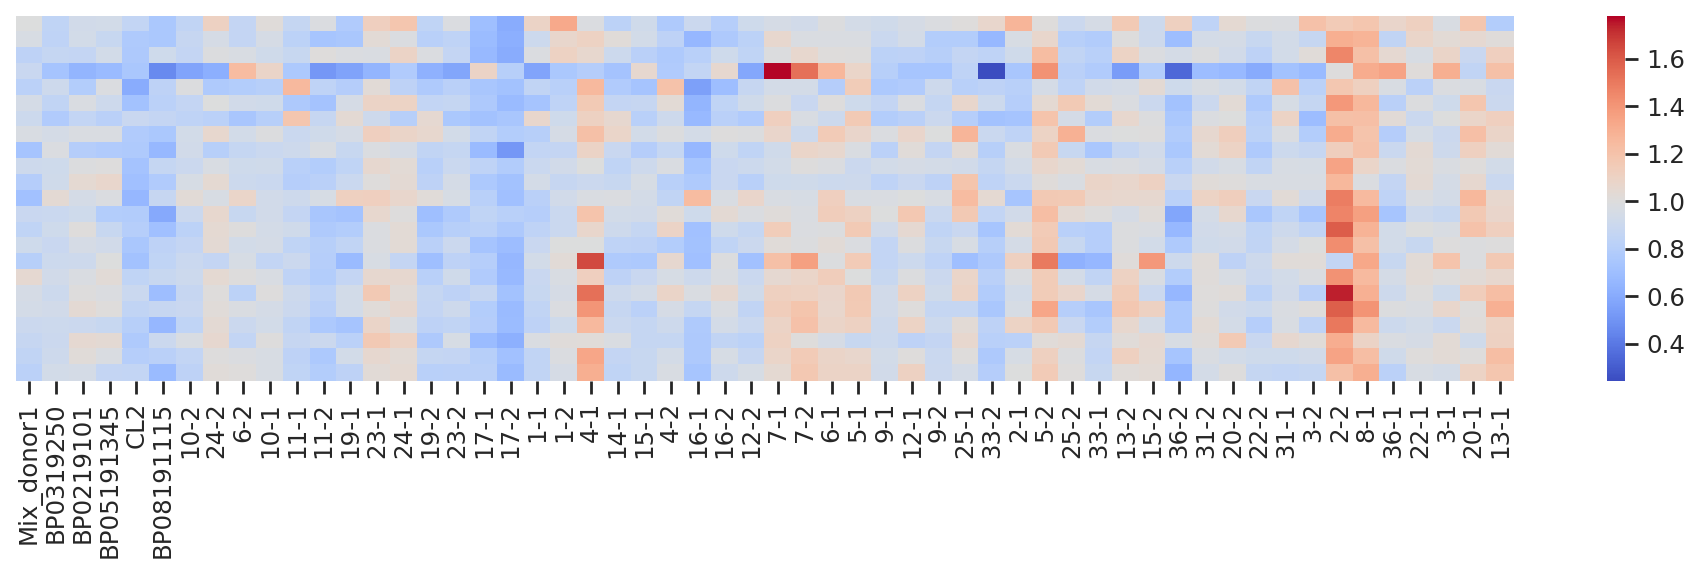

In [19]:
df_corresponding = plot_corresponding(p, sig_pathways, adata)

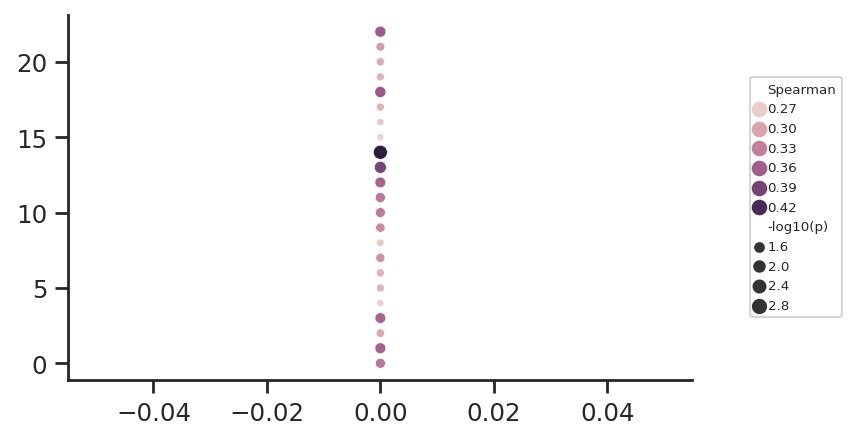

In [20]:
plot_spearman_dots(sig_pathways, df_corresponding)

#### Effectors only

In [24]:
effectors = ['0', '2', '8']
adata_effectors = adata[adata.obs['louvain'].isin(effectors)].copy()
adata_metab_effectors = adata_metab[adata.obs['louvain'].isin(effectors)].copy()
# Not using subpopulations here for now
p = pathway_activity(adata_effectors, adata_metab_effectors, 'patient', print_labels=True)

1-1
1-2
10-1
10-2
11-1
11-2
12-1
12-2
13-1
13-2
14-1
15-1
15-2
16-1
16-2
17-1
17-2
19-1
19-2
2-1
2-2
20-1
20-2
22-1
22-2
23-1
23-2
24-1
24-2
25-1
25-2
3-1
3-2
31-1
31-2
33-1
33-2
36-1
36-2
4-1
4-2
5-1
5-2
6-1
6-2
7-1
7-2
8-1
9-1
9-2
BP0219101
BP0319250
BP05191345
BP08191115
CL2
Mix_donor1


Text(0.5, 92.00000000000001, '')

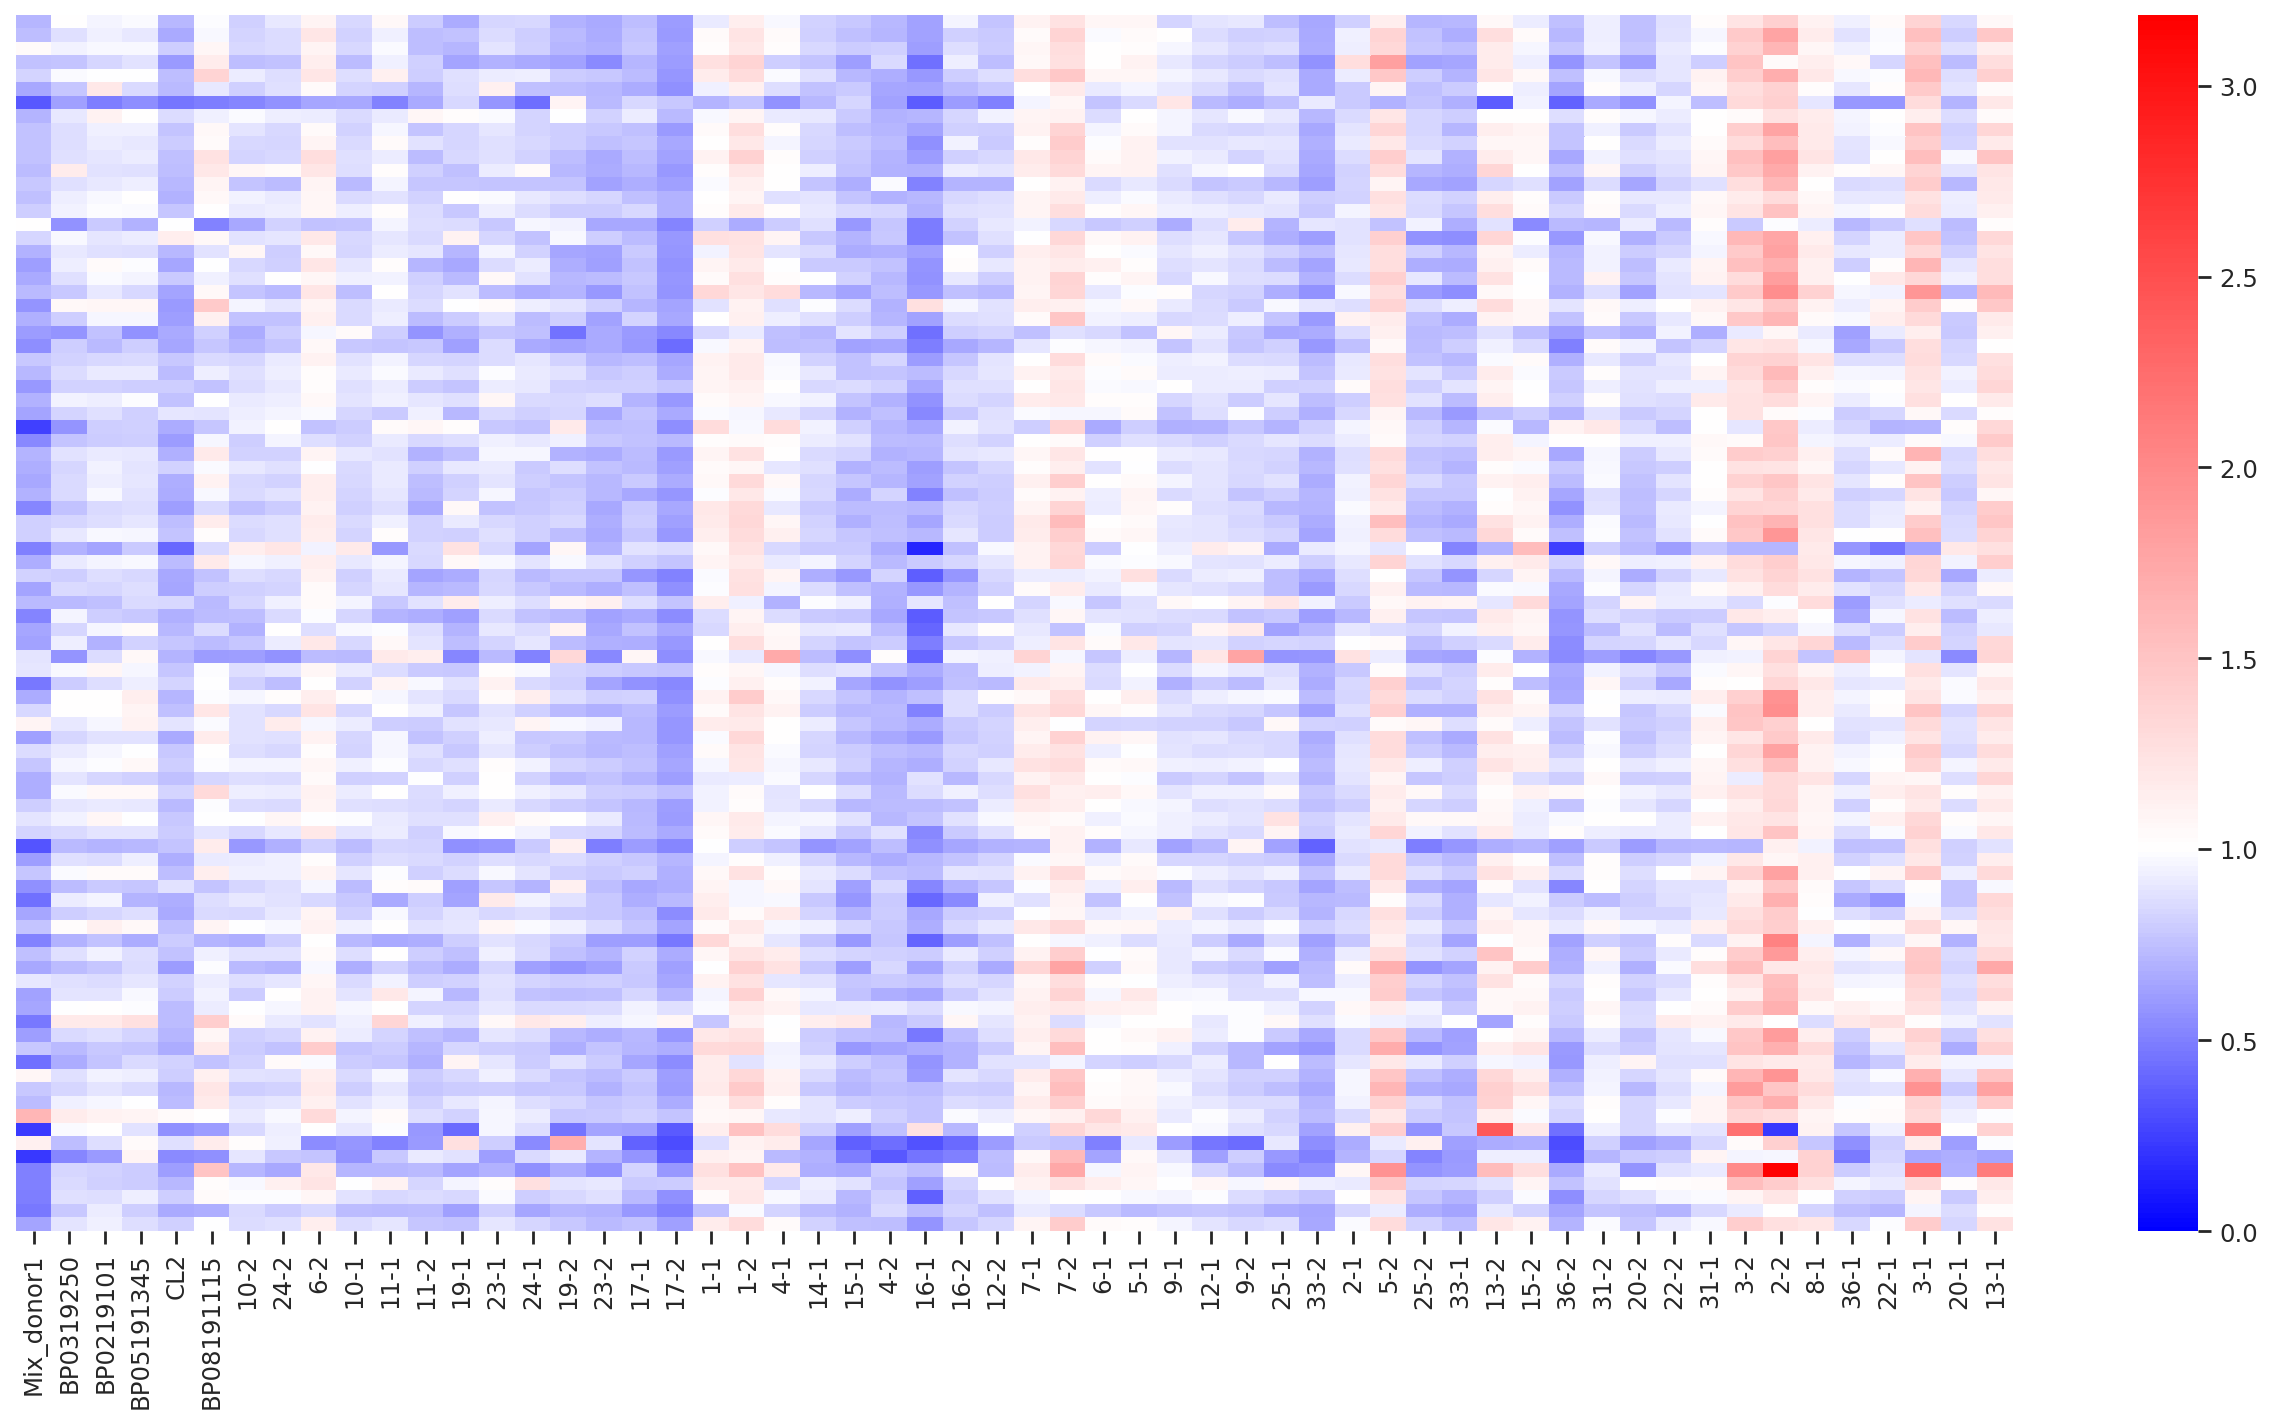

In [137]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 10))
ax = sns.heatmap(df_p, cmap='bwr', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

In [ ]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x

n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata_effectors.obs['patient'])
    adata_effectors.obs['patient_shuffled'] = clusters_shuffled
    adata_metab_effectors.obs['patient_shuffled'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata_effectors, adata_metab_effectors, 'patient_shuffled')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-patient-cluster_0_2_8-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [ ]:
df_p = pd.DataFrame(p_sig)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 10))
ax = sns.heatmap(df_p, cmap='bwr', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

In [138]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[0], 
                      axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[1], 
                         axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
sig_pathways['-log10(p)'] = -np.log10(sig_pathways['p-value'])
pd.DataFrame(sig_pathways).to_csv(master_dir + 'output/pathway_activity/pathway_activity_trends/' + 
                                 celltype + '-cluster_0_2_8' + '.csv')
sig_pathways

Spearman   p-value  \
0                                                                        
alpha-Linolenic acid metabolism                     0.547025  0.000013   
Ether lipid metabolism                              0.520478  0.000039   
Glycosaminoglycan biosynthesis - heparan sulfat...  0.455623  0.000418   
Ascorbate and aldarate metabolism                   0.406598  0.001873   
Vitamin B6 metabolism                               0.400857  0.002202   
Glycerophospholipid metabolism                      0.391881  0.002818   
Riboflavin metabolism                               0.379564  0.003912   
Retinol metabolism                                  0.376850  0.004199   
Mucin type O-glycan biosynthesis                    0.363837  0.005843   
Arginine and proline metabolism                     0.357644  0.006807   
Steroid biosynthesis                                0.356496  0.007000   
Biotin metabolism                                   0.356078  0.007072   
Pantothenate and CoA biosynthesis                   0.354095  0.007420   
Thiamine metabolism                                 0.353747  0.007482   
Cutin, suberine and wax biosynthesis                0.348876  0.008408   
Mannose type O-glycan biosynthesis                  0.347762  0.008633   
Steroid hormone biosynthesis                        0.347380  0.008712   
Glycine, serine and threonine metabolism            0.345083  0.009196   
Primary bile acid biosynthesis                      0.340838  0.010154   
Glyoxylate and dicarboxylate metabolism             0.340143  0.010319   
Galactose metabolism                                0.340108  0.010327   
Nicotinate and nicotinamide metabolism              0.337881  0.010871   
Fatty acid degradation                              0.335167  0.011567   
Glycosaminoglycan biosynthesis - chondroitin su...  0.328800  0.013352   
Pyrimidine metabolism                               0.328661  0.013394   
Pyruvate metabolism                                 0.323476  0.015022   
Oxidative phosphorylation                           0.318362  0.016791   
Tyrosine metabolism                                 0.312690  0.018958   
Glycosylphosphatidylinositol (GPI)-anchor biosy...  0.312029  0.019225   
Prodigiosin biosynthesis                            0.305697  0.021953   
Glycosphingolipid biosynthesis - ganglio series     0.305384  0.022096   
Terpenoid backbone biosynthesis                     0.304375  0.022562   
Biosynthesis of unsaturated fatty acids             0.302531  0.023435   
Tryptophan metabolism                               0.301591  0.023891   
Glycerolipid metabolism                             0.300930  0.024216   
Various types of N-glycan biosynthesis              0.295989  0.026766   
Folate biosynthesis                                 0.294980  0.027314   
Other types of O-glycan biosynthesis                0.294528  0.027562   
Fatty acid biosynthesis                             0.293310  0.028240   
Citrate cycle (TCA cycle)                           0.290701  0.029741   
Aflatoxin biosynthesis                              0.290527  0.029844   
Amino sugar and nucleotide sugar metabolism         0.283533  0.034210   
Sphingolipid metabolism                             0.278906  0.037382   
Fatty acid elongation                               0.278488  0.037680   
Glutathione metabolism                              0.275044  0.040212   
Drug metabolism - other enzymes                     0.272643  0.042058   
Other glycan degradation                            0.271773  0.042744   
Valine, leucine and isoleucine degradation          0.267180  0.046519   

                                                    Spearman_abs  -log10(p)  
0                                                                            
alpha-Linolenic acid metabolism                         0.547025   4.890469  
Ether lipid metabolism                                  0.520478   4.406251  
Glycosaminoglycan biosynthesis - hepara

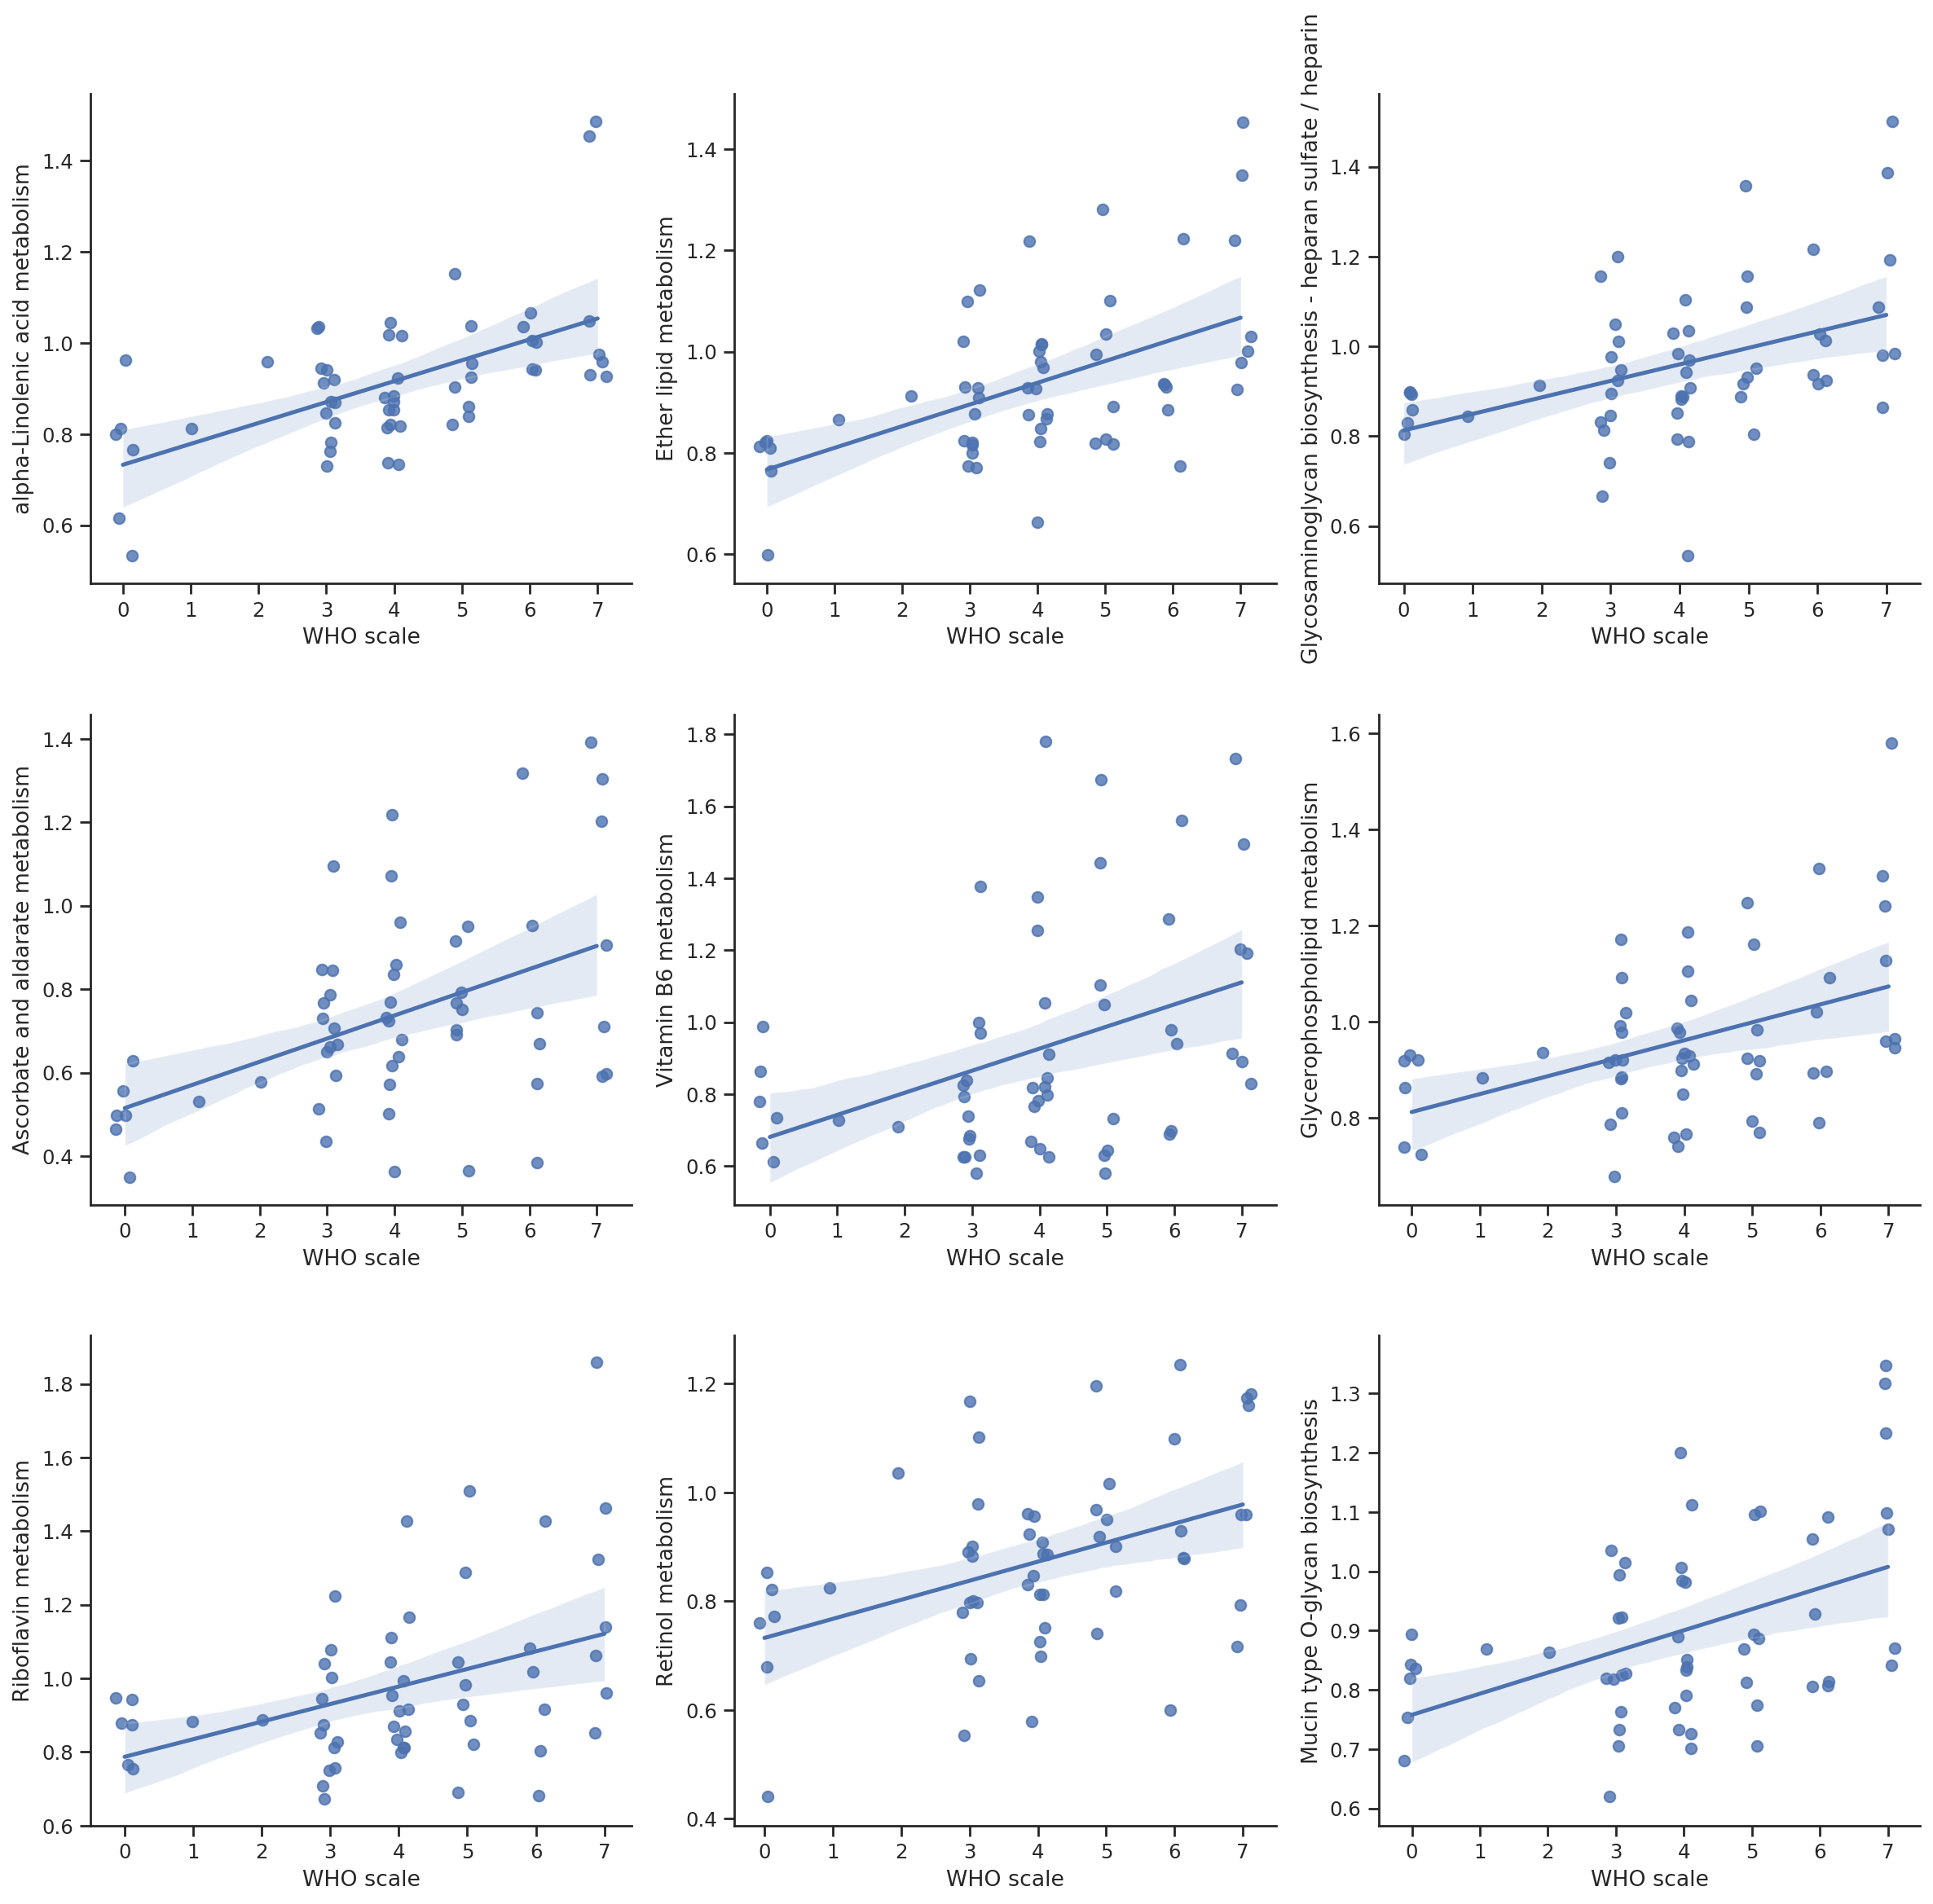

In [139]:
# Plot the top corresponding ones
sns.set_style('white')
sns.set_style('ticks')
f, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=False)
sns.despine()

k = 0
x = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
for i in range(3):
    for j in range(3):
        f = sns.regplot(x=x, y=df_p.loc[sig_pathways.index[k]], x_jitter=0.15, ax=axes[i, j])
        f.set_ylabel(sig_pathways.index[k])
        f.set_xlabel('WHO scale')
        f.set_xticks(range(8))
        k += 1

plt.tight_layout()

0
Arginine and proline metabolism                                                                  Amino acid metabolism
Glycine, serine and threonine metabolism                                                         Amino acid metabolism
Tyrosine metabolism                                                                              Amino acid metabolism
Tryptophan metabolism                                                                            Amino acid metabolism
Valine, leucine and isoleucine degradation                                                       Amino acid metabolism
Prodigiosin biosynthesis                                                   Biosynthesis of other secondary metabolites
Aflatoxin biosynthesis                                                     Biosynthesis of other secondary metabolites
Ascorbate and aldarate metabolism                                                              Carbohydrate metabolism
Glyoxylate and dicarboxylate metabolism       

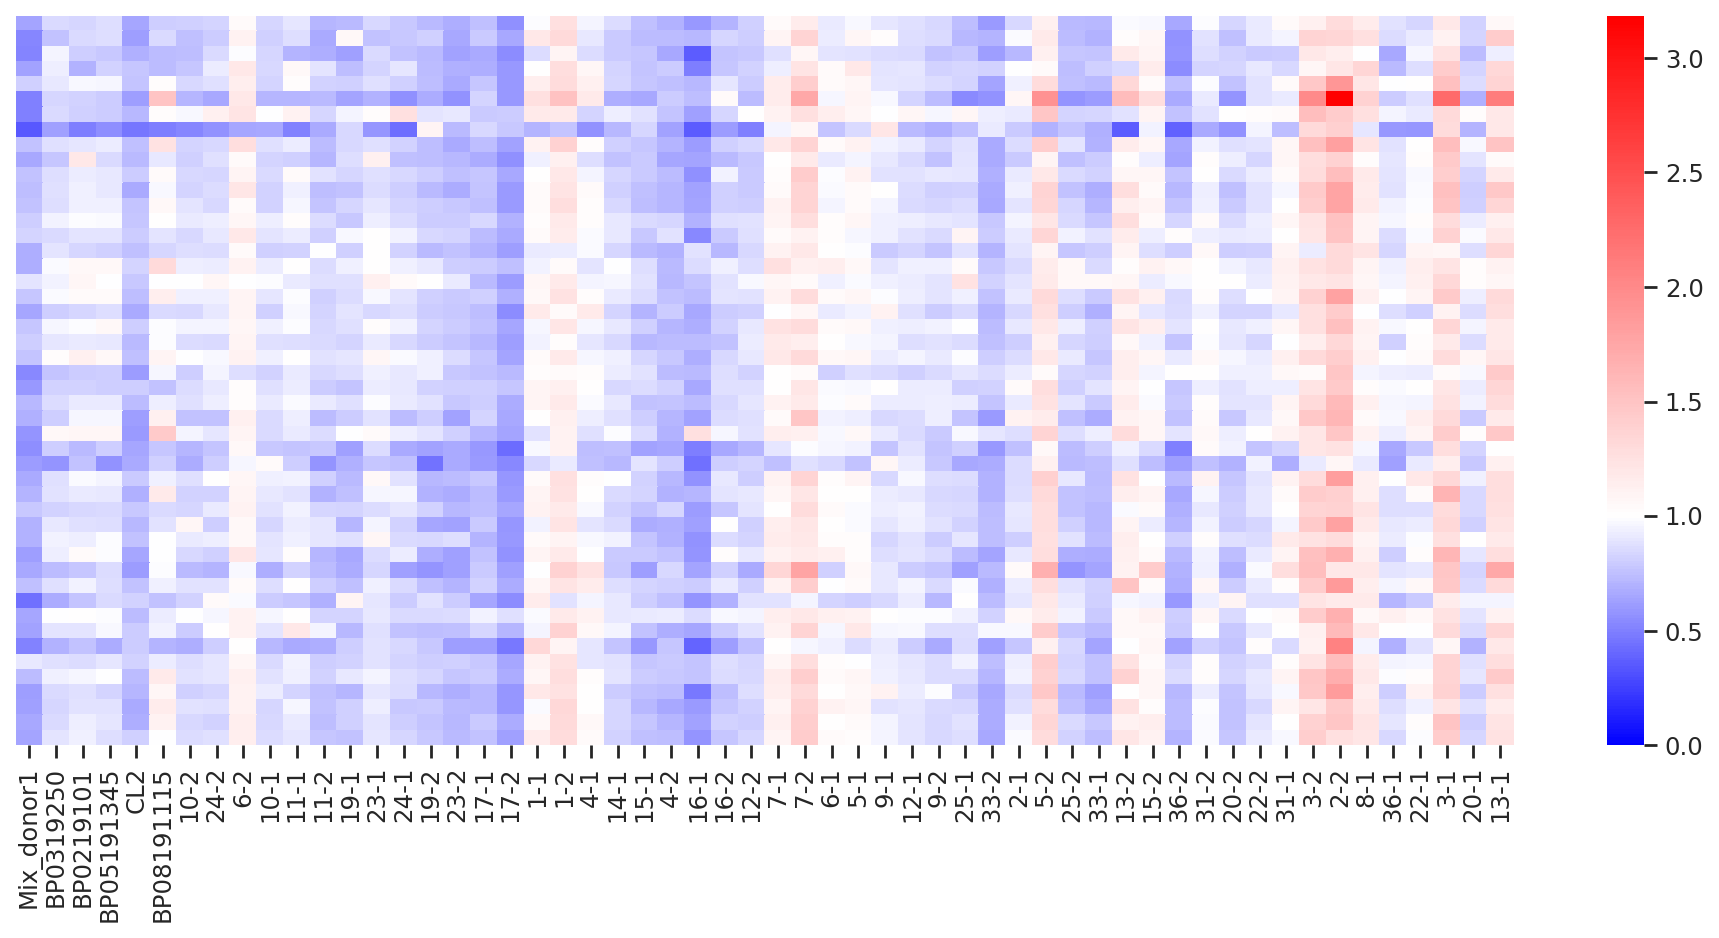

In [141]:
df_corresponding = plot_corresponding(p, sig_pathways, adata, figsize=(15, 6))

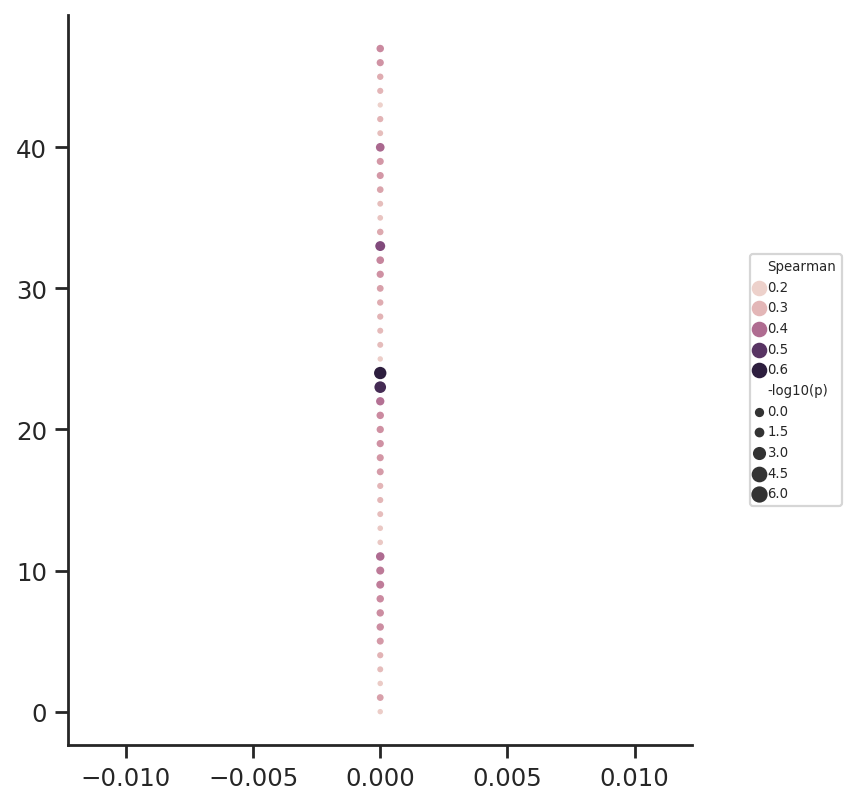

In [142]:
plot_spearman_dots(sig_pathways, df_corresponding, figsize=(5, 6))

#### Effector clusters only (METABOLIC clusters 0, 4, 5 with effector markers)

In [13]:
adata.obs['louvain_metab'] = adata_metab.obs['louvain']

In [26]:
eff_metab = ['0', '4', '5']
adata_eff_metab = adata[adata.obs['louvain_metab'].isin(eff_metab)].copy()
adata_metab_eff_metab = adata_metab[adata.obs['louvain_metab'].isin(eff_metab)].copy()
# Not using subpopulations here for now
p = pathway_activity(adata_eff_metab, adata_metab_eff_metab, 'patient', print_labels=True)

1-1
1-2
10-1
10-2
11-1
11-2
12-1
12-2
13-1
13-2
14-1
15-1
15-2
16-1
16-2
17-1
17-2
19-1
19-2
2-1
2-2
20-1
20-2
22-1
22-2
23-1
23-2
24-1
24-2
25-1
25-2
3-1
3-2
31-1
31-2
33-1
33-2
36-1
36-2
4-1
4-2
5-1
5-2
6-1
6-2
7-1
7-2
8-1
9-1
9-2
BP0219101
BP0319250
BP05191345
BP08191115
CL2
Mix_donor1


In [ ]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x

n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata_mem.obs['patient'])
    adata_mem.obs['patient_shuffled'] = clusters_shuffled
    adata_metab_mem.obs['patient_shuffled'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata_mem, adata_metab_mem, 'patient_shuffled')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-patient-cluster_3_6-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

In [19]:
df_p = pd.DataFrame(p_sig)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 25))
ax = sns.heatmap(df_p, cmap='bwr', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))

NameError: name 'p_sig' is not defined

<ipython-input-27-c4520182ece6>:16: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


Text(0.5, 92.00000000000001, '')

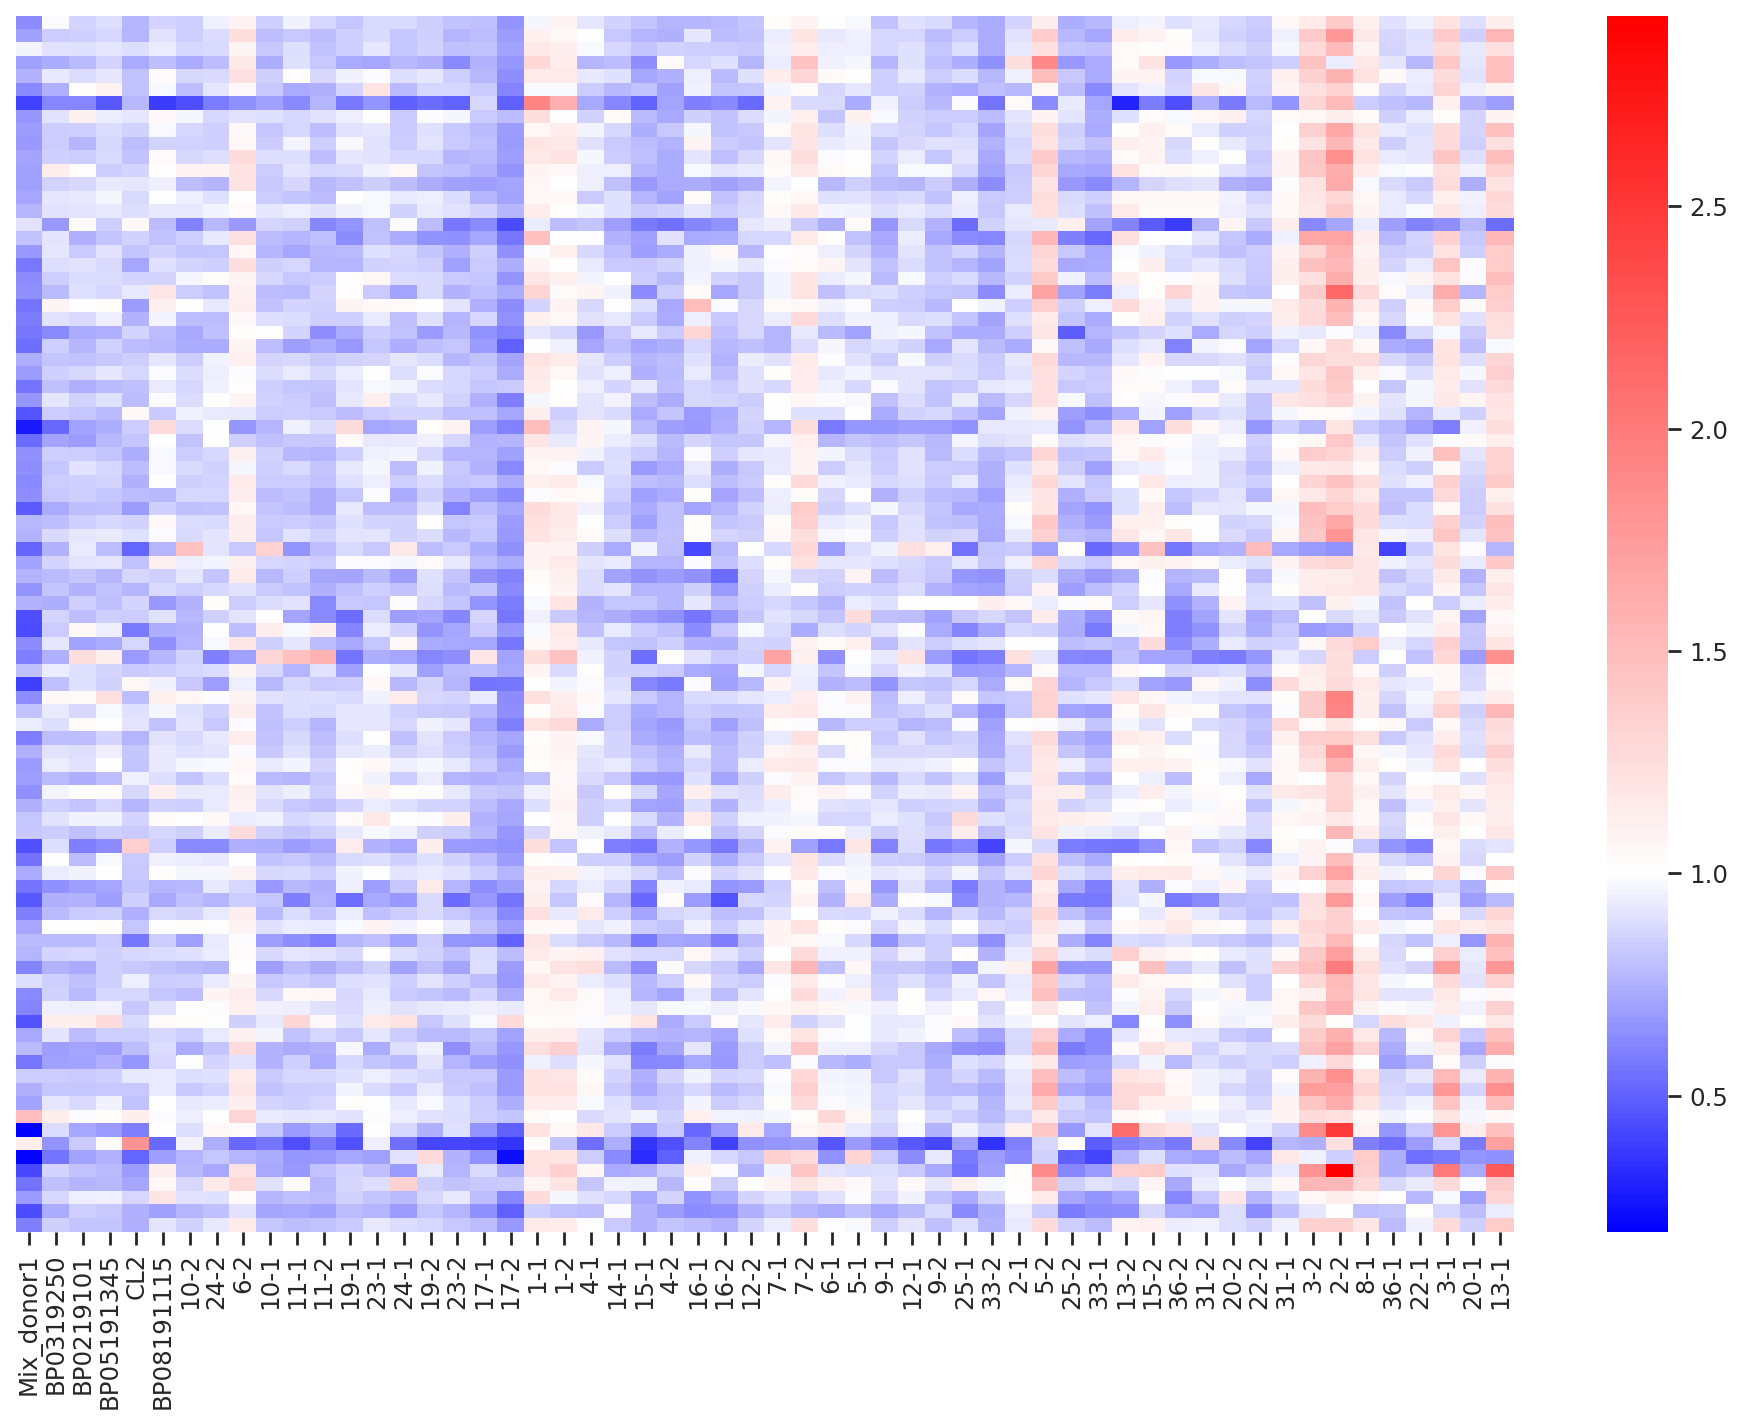

In [27]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(15, 10))
ax = sns.heatmap(df_p, cmap='bwr', yticklabels=[], vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

In [28]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[0], 
                      axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[1], 
                         axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
sig_pathways['-log10(p)'] = -np.log10(sig_pathways['p-value'])
#pd.DataFrame(sig_pathways).to_csv(master_dir + 'output/pathway_activity/pathway_activity_trends/' + 
#                                 celltype + '-metab_cluster_0_4_5' + '.csv')
sig_pathways

Spearman   p-value  \
0                                                                        
Glycosaminoglycan biosynthesis - heparan sulfat...  0.565953  0.000005   
Riboflavin metabolism                               0.526045  0.000031   
Vitamin B6 metabolism                               0.500506  0.000086   
Nicotinate and nicotinamide metabolism              0.488363  0.000134   
Biotin metabolism                                   0.468809  0.000268   
...                                                      ...       ...   
Purine metabolism                                   0.297033  0.026209   
Taurine and hypotaurine metabolism                  0.288439  0.031096   
Pentose phosphate pathway                           0.276888  0.038839   
Prodigiosin biosynthesis                            0.274313  0.040766   
Sulfur metabolism                                   0.272643  0.042058   

                                                    Spearman_abs  -log10(p)  
0                                                                            
Glycosaminoglycan biosynthesis - heparan sulfat...      0.565953   5.261705  
Riboflavin metabolism                                   0.526045   4.504447  
Vitamin B6 metabolism                                   0.500506   4.067726  
Nicotinate and nicotinamide metabolism                  0.488363   3.871939  
Biotin metabolism                                       0.468809   3.571662  
...                                                          ...        ...  
Purine metabolism                                       0.297033   1.581545  
Taurine and hypotaurine metabolism                      0.288439   1.507301  
Pentose phosphate pathway                               0.276888   1.410729  
Prodigiosin biosynthesis                                0.274313   1.389699  
Sulfur metabolism                                       0.272643   1.376152  

[65 rows x 4 columns]

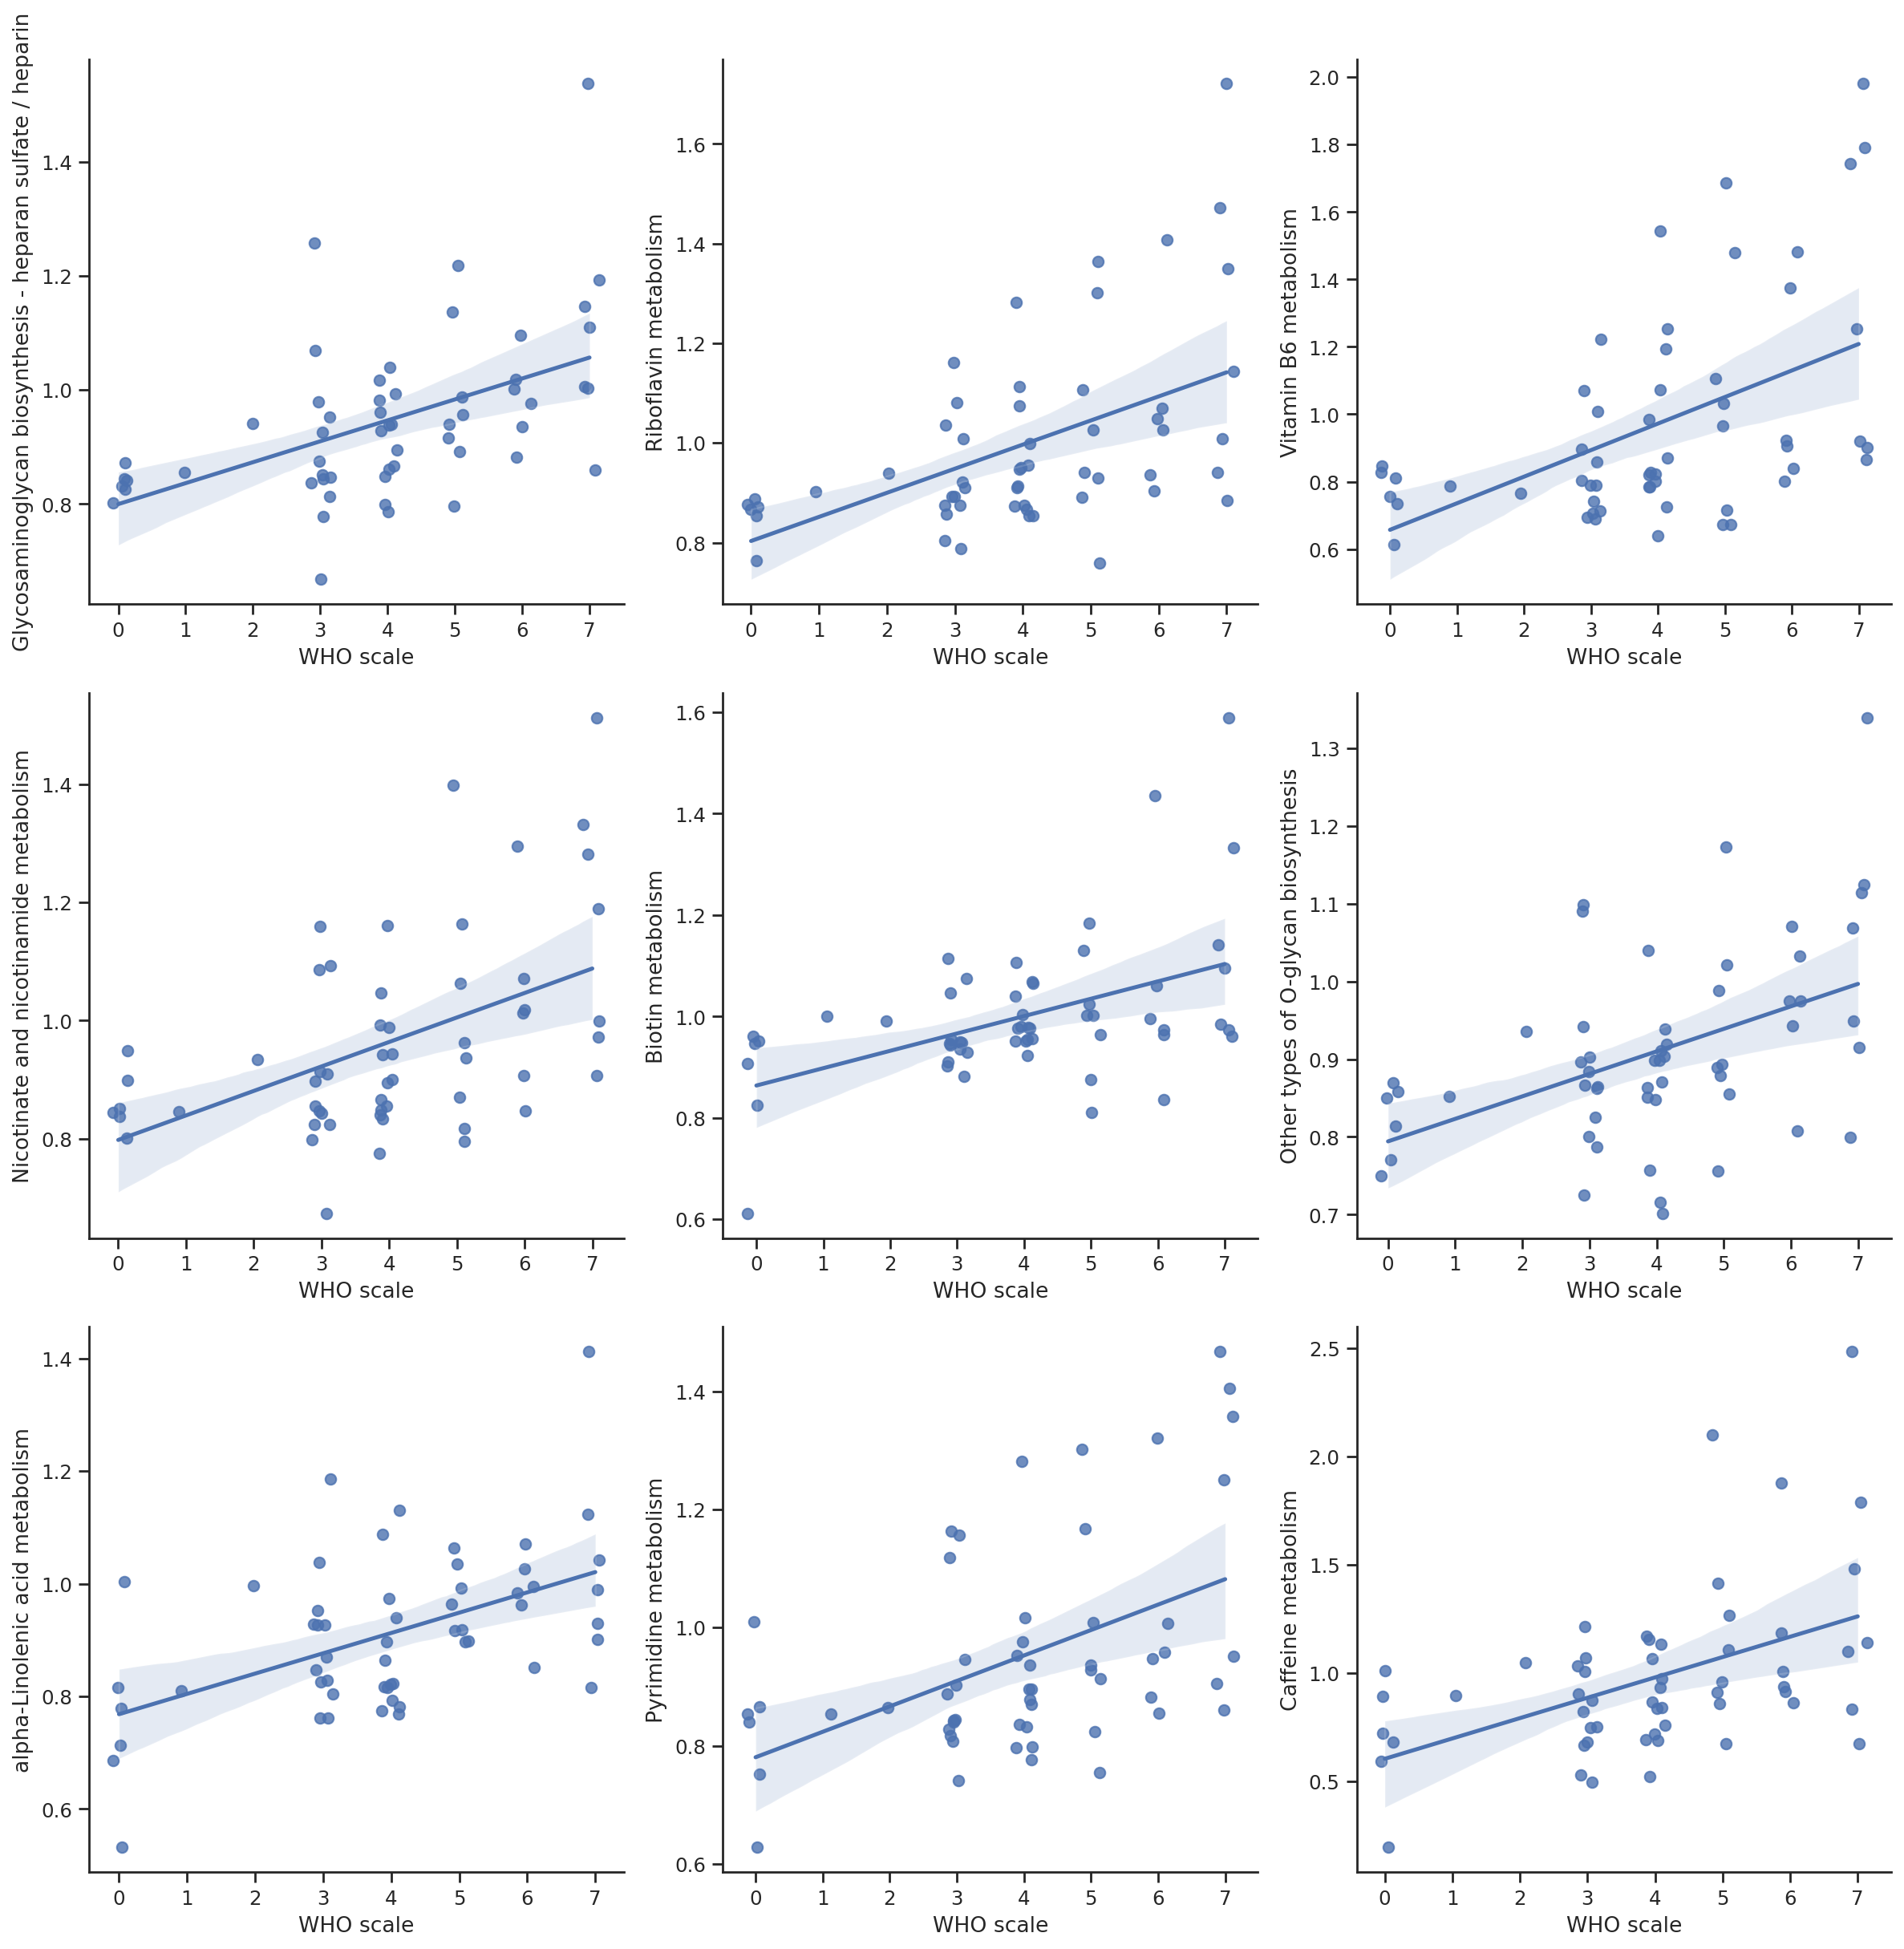

In [29]:
# Plot the top corresponding ones
sns.set_style('white')
sns.set_style('ticks')
f, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=False)
sns.despine()

k = 0
x = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
for i in range(3):
    for j in range(3):
        f = sns.regplot(x=x, y=df_p.loc[sig_pathways.index[k]], x_jitter=0.15, ax=axes[i, j])
        f.set_ylabel(sig_pathways.index[k])
        f.set_xlabel('WHO scale')
        f.set_xticks(range(8))
        k += 1

plt.tight_layout()

0
Glycine, serine and threonine metabolism                       Amino acid metabolism
Arginine and proline metabolism                                Amino acid metabolism
Tryptophan metabolism                                          Amino acid metabolism
Histidine metabolism                                           Amino acid metabolism
Valine, leucine and isoleucine degradation                     Amino acid metabolism
                                                               ...                  
Glutathione metabolism                               Metabolism of other amino acids
Taurine and hypotaurine metabolism                   Metabolism of other amino acids
Pyrimidine metabolism                                          Nucleotide metabolism
Purine metabolism                                              Nucleotide metabolism
Drug metabolism - other enzymes               Xenobiotics degradation and metabolism
Name: category, Length: 65, dtype: object


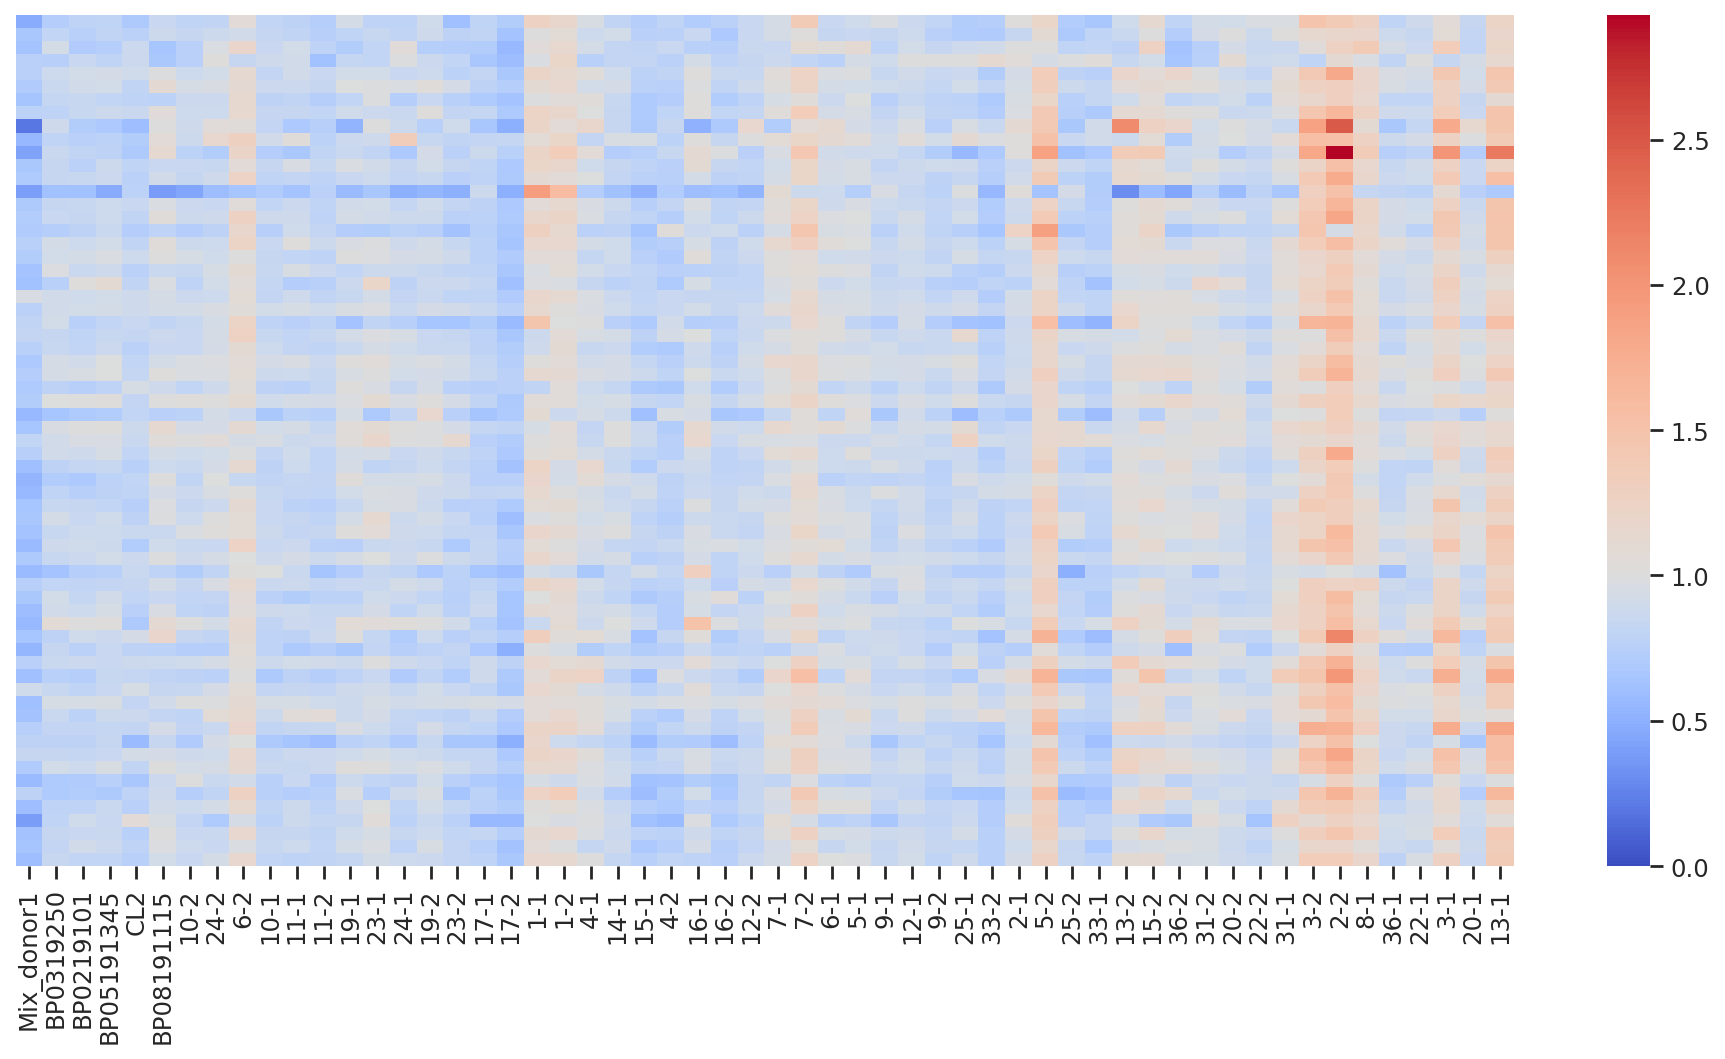

In [50]:
df_corresponding = plot_corresponding(p, sig_pathways, adata, figsize=(15, 7))

In [24]:
df_corresponding.index.map(classifications)

Index(['Amino acid metabolism', 'Amino acid metabolism',
       'Amino acid metabolism', 'Amino acid metabolism',
       'Amino acid metabolism', 'Amino acid metabolism',
       'Amino acid metabolism', 'Amino acid metabolism',
       'Biosynthesis of other secondary metabolites',
       'Biosynthesis of other secondary metabolites',
       'Biosynthesis of other secondary metabolites',
       'Carbohydrate metabolism', 'Carbohydrate metabolism',
       'Carbohydrate metabolism', 'Carbohydrate metabolism',
       'Carbohydrate metabolism', 'Carbohydrate metabolism',
       'Carbohydrate metabolism', 'Carbohydrate metabolism',
       'Carbohydrate metabolism', 'Carbohydrate metabolism',
       'Carbohydrate metabolism', 'Energy metabolism', 'Energy metabolism',
       'Glycan biosynthesis and metabolism',
       'Glycan biosynthesis and metabolism',
       'Glycan biosynthesis and metabolism',
       'Glycan biosynthesis and metabolism',
       'Glycan biosynthesis and metabolism',
    

In [26]:
df_corresponding.index

Index(['Glycine, serine and threonine metabolism',
       'Arginine and proline metabolism', 'Tryptophan metabolism',
       'Histidine metabolism', 'Valine, leucine and isoleucine degradation',
       'Lysine degradation', 'Alanine, aspartate and glutamate metabolism',
       'Cysteine and methionine metabolism', 'Caffeine metabolism',
       'Aflatoxin biosynthesis', 'Prodigiosin biosynthesis',
       'Pyruvate metabolism', 'Citrate cycle (TCA cycle)',
       'Ascorbate and aldarate metabolism',
       'Amino sugar and nucleotide sugar metabolism',
       'Glyoxylate and dicarboxylate metabolism',
       'Pentose and glucuronate interconversions',
       'Fructose and mannose metabolism', 'Inositol phosphate metabolism',
       'Glycolysis / Gluconeogenesis', 'Galactose metabolism',
       'Pentose phosphate pathway', 'Oxidative phosphorylation',
       'Sulfur metabolism',
       'Glycosaminoglycan biosynthesis - heparan sulfate / heparin',
       'Other types of O-glycan biosynthes

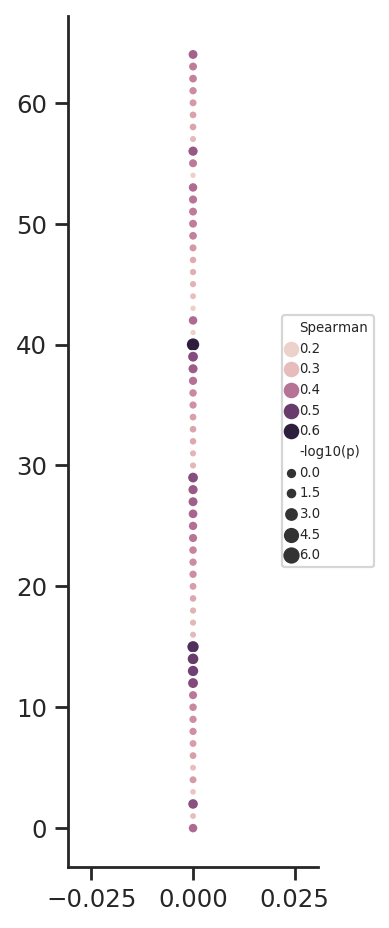

In [25]:
plot_spearman_dots(sig_pathways, df_corresponding, figsize=(2, 7))

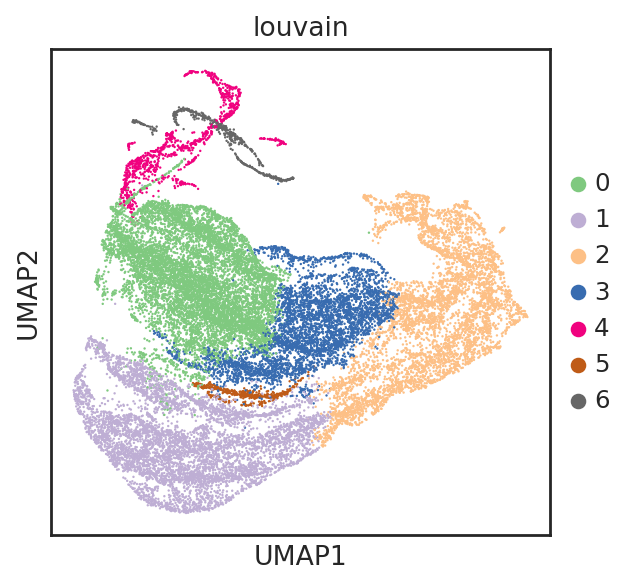

In [86]:
sc.pl.umap(adata_metab, color='louvain', palette='Accent')

patients_healthy = adata.obs[adata.obs['ICU_status']=='Healthy'].loc[:, 'patient'].unique()
patients_non_ICU = adata.obs[adata.obs['ICU_status']=='Non-ICU'].loc[:, 'patient'].unique()
patients_ICU = adata.obs[adata.obs['ICU_status']=='ICU'].loc[:, 'patient'].unique()

Text(0, 0.5, '')

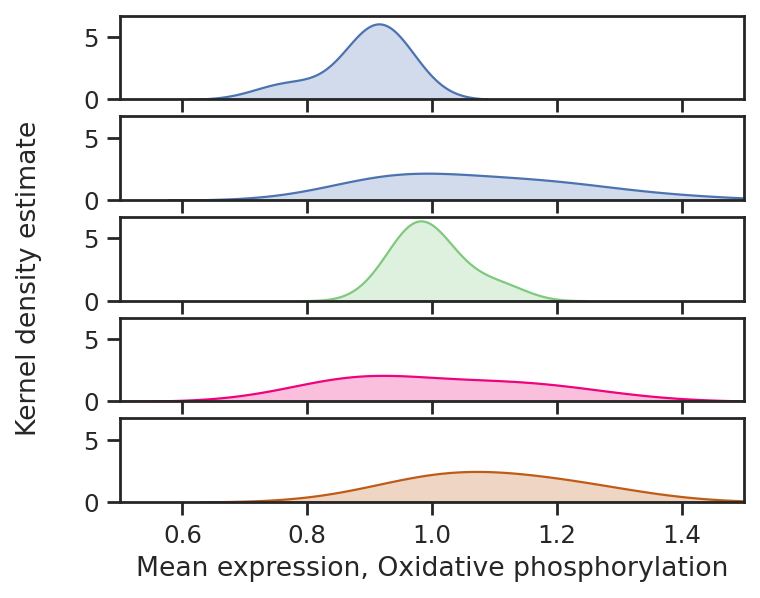

In [100]:
# Kernel density estimate plot of 
# T cell functional markers
sns.set_style('white')
sns.set_style('ticks')

pathway_name = 'Oxidative phosphorylation'
gene = metab_genes_dict[pathway_name]

eff_metab = ['0']
adata_eff_metab = adata[adata.obs['louvain_metab'].isin(eff_metab)].copy()
adata_metab_eff_metab = adata_metab[adata.obs['louvain_metab'].isin(eff_metab)].copy()
icu_0 = pd.DataFrame(pathway_activity(adata_eff_metab, adata_metab_eff_metab, 'patient'))
icu_0.index = metab_genes.index
patients_0 = adata_eff_metab.obs['patient'].unique().astype(str)
patients_0.sort()
icu_0.columns = patients_0

eff_metab = ['4']
adata_eff_metab = adata[adata.obs['louvain_metab'].isin(eff_metab)].copy()
adata_metab_eff_metab = adata_metab[adata.obs['louvain_metab'].isin(eff_metab)].copy()
icu_4 = pd.DataFrame(pathway_activity(adata_eff_metab, adata_metab_eff_metab, 'patient'))
icu_4.index = metab_genes.index
patients_4 = adata_eff_metab.obs['patient'].unique().astype(str)
patients_4.sort()
icu_4.columns = patients_4

eff_metab = ['5']
adata_eff_metab = adata[adata.obs['louvain_metab'].isin(eff_metab)].copy()
adata_metab_eff_metab = adata_metab[adata.obs['louvain_metab'].isin(eff_metab)].copy()
icu_5 = pd.DataFrame(pathway_activity(adata_eff_metab, adata_metab_eff_metab, 'patient'))
icu_5.index = metab_genes.index
patients_5 = adata_eff_metab.obs['patient'].unique().astype(str)
patients_5.sort()
icu_5.columns = patients_5


f, axes = plt.subplots(5, 1, figsize=(5, 4), sharex=True, sharey=True)
f.text(0.05, 0.5, 'Kernel density estimate', va='center', rotation='vertical')
f = plt.xlabel('Mean expression, ' + pathway_name)
f = plt.xlim((0.5, 1.5))
f = plt.yticks([0, 5])

bins = np.arange(0, 2.5, 0.01)
bw = 1.25
f = sns.kdeplot(df_p.loc[pathway_name, patients_healthy], shade=True, ax=axes[0], legend=None, bw_adjust=bw)
axes[0].set_ylabel('') 
f = sns.kdeplot(df_p.loc[pathway_name, patients_ICU], shade=True, ax=axes[1], legend=None, bw_adjust=bw)
axes[1].set_ylabel('') 
f = sns.kdeplot(icu_0.loc[pathway_name, set(patients_ICU).intersection(patients_0)],
                color=adata_metab.uns['louvain_colors'][0], shade=True, ax=axes[2], legend=None, bw_adjust=bw)
axes[2].set_ylabel('') 
f = sns.kdeplot(icu_4.loc[pathway_name, set(patients_ICU).intersection(patients_4)],
                color=adata_metab.uns['louvain_colors'][4], shade=True, ax=axes[3], legend=None, bw_adjust=bw)
axes[3].set_ylabel('') 
f = sns.kdeplot(icu_5.loc[pathway_name, set(patients_ICU).intersection(patients_5)],
                color=adata_metab.uns['louvain_colors'][5], shade=True, ax=axes[4], legend=None, bw_adjust=bw)
axes[4].set_ylabel('') 
#plt.savefig(master_dir + 'output/cd8-Fatty_acid_biosynthesis-GEX.pdf')

In [24]:
adata_obs_by_patient = adata.obs.copy()
adata_obs_by_patient.index = adata_obs_by_patient['patient']
#adata_obs_by_patient.groupby(by='patient').first()
adata_obs_by_patient = adata_obs_by_patient.reset_index(drop=True)
adata_obs_by_patient = adata_obs_by_patient.groupby(by='patient').first() # All characteristics except clustering should be the same
adata_obs_by_patient['WHO_scale'] = adata_obs_by_patient['WHO_scale'].astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].str.replace('Not Recorded', 
                                                                                              '0').astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].astype(int)

eff_metab = ['4']
adata_eff_metab = adata[adata.obs['louvain_metab'].isin(eff_metab)].copy()
adata_metab_eff_metab = adata_metab[adata.obs['louvain_metab'].isin(eff_metab)].copy()
# Not using subpopulations here for now
p = pathway_activity(adata_eff_metab, adata_metab_eff_metab, 'patient')#, print_labels=True)

df_p = pd.DataFrame(p)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab_cluster_4'
            '-metab-patient-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

df_p.index = metab_genes.index
patients = adata_eff_metab.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
df_p = df_p.reindex(columns=patients_WHO)#, fill_value=1)

spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']],
                                           nan_policy='omit')[0], axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']],
                                           nan_policy='omit')[1], axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
sig_pathways['-log10(p)'] = -np.log10(sig_pathways['p-value'])
pd.DataFrame(sig_pathways).to_csv(master_dir + 'output/pathway_activity/pathway_activity_trends/' + 
                                 celltype + '-metab_cluster_4' + '.csv')
sig_pathways

Spearman   p-value  \
0                                                                        
Tyrosine metabolism                                 0.439417  0.002000   
Alanine, aspartate and glutamate metabolism         0.432394  0.002403   
Pyruvate metabolism                                 0.421120  0.003201   
Pyrimidine metabolism                               0.413802  0.003836   
Steroid hormone biosynthesis                        0.405834  0.004651   
Mannose type O-glycan biosynthesis                  0.402706  0.005010   
Cutin, suberine and wax biosynthesis                0.401466  0.005159   
Galactose metabolism                                0.396981  0.005731   
Glycerolipid metabolism                             0.396272  0.005826   
Vitamin B6 metabolism                               0.393498  0.006211   
Glycolysis / Gluconeogenesis                        0.392849  0.006305   
Glycosaminoglycan biosynthesis - chondroitin su...  0.390252  0.006691   
Biosynthesis of unsaturated fatty acids             0.385353  0.007475   
Steroid biosynthesis                                0.385117  0.007515   
Starch and sucrose metabolism                       0.370716  0.010312   
Terpenoid backbone biosynthesis                     0.370657  0.010325   
Pantothenate and CoA biosynthesis                   0.356964  0.013775   
Other types of O-glycan biosynthesis                0.348288  0.016436   
Drug metabolism - other enzymes                     0.348111  0.016494   
Glutathione metabolism                              0.346045  0.017190   
Glyoxylate and dicarboxylate metabolism             0.340674  0.019118   
Prodigiosin biosynthesis                            0.340556  0.019162   
Valine, leucine and isoleucine biosynthesis         0.340497  0.019184   
Other glycan degradation                            0.339375  0.019610   
Sphingolipid metabolism                             0.339139  0.019701   
Glycerophospholipid metabolism                      0.337664  0.020276   
Cysteine and methionine metabolism                  0.328515  0.024164   
Amino sugar and nucleotide sugar metabolism         0.327276  0.024735   
Citrate cycle (TCA cycle)                           0.322141  0.027227   
Porphyrin and chlorophyll metabolism                0.320075  0.028286   
Thiamine metabolism                                 0.315294  0.030870   
Synthesis and degradation of ketone bodies          0.313052  0.032149   
D-Glutamine and D-glutamate metabolism              0.310396  0.033718   
Pentose and glucuronate interconversions            0.309215  0.034436   
Purine metabolism                                   0.306500  0.036135   
Folate biosynthesis                                 0.298414  0.041608   
Glycosylphosphatidylinositol (GPI)-anchor biosy...  0.292040  0.046385   
Arginine and proline metabolism                     0.288617  0.049129   

                                                    Spearman_abs  -log10(p)  
0                                                                            
Tyrosine metabolism                                     0.439417   2.698973  
Alanine, aspartate and glutamate metabolism             0.432394   2.619238  
Pyruvate metabolism                                     0.421120   2.494716  
Pyrimidine metabolism                                   0.413802   2.416097  
Steroid hormone biosynthesis                            0.405834   2.332441  
Mannose type O-glycan biosynthesis                      0.402706   2.300140  
Cutin, suberine and wax biosynthesis                    0.401466   2.287425  
Galactose metabolism                                    0.396981   2.241802  
Glycerolipid metabolism                                 0.396272   2.234654  
Vitamin B6 metabolism                                   0.393498   2.206804  
Glycolysis / Gluconeogenesis                            0.392849   2.200320  
Glycosaminoglycan biosynthesis - chondroitin su...      0.390252   2.174507  

#### Memory clusters only

In [193]:
mem = ['3', '6']
adata_mem = adata[adata.obs['louvain'].isin(mem)].copy()
adata_metab_mem = adata_metab[adata.obs['louvain'].isin(mem)].copy()
# Not using subpopulations here for now
p = pathway_activity(adata_mem, adata_metab_mem, 'patient', print_labels=True)

1-1
1-2
10-1
10-2
11-1
11-2
12-1
12-2
13-1
13-2
14-1
15-1
15-2
16-1
16-2
17-1
17-2
19-1
19-2
2-1
2-2
20-1
20-2
22-1
22-2
23-1
23-2
24-1
24-2
25-1
25-2
3-1
3-2
31-1
31-2
33-1
33-2
36-1
36-2
4-1
4-2
5-1
5-2
6-1
6-2
7-1
7-2
8-1
9-1
9-2
BP0219101
BP0319250
BP05191345
BP08191115
CL2
Mix_donor1


In [194]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x

n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata_mem.obs['patient'])
    adata_mem.obs['patient_shuffled'] = clusters_shuffled
    adata_metab_mem.obs['patient_shuffled'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata_mem, adata_metab_mem, 'patient_shuffled')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-patient-cluster_3_6-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


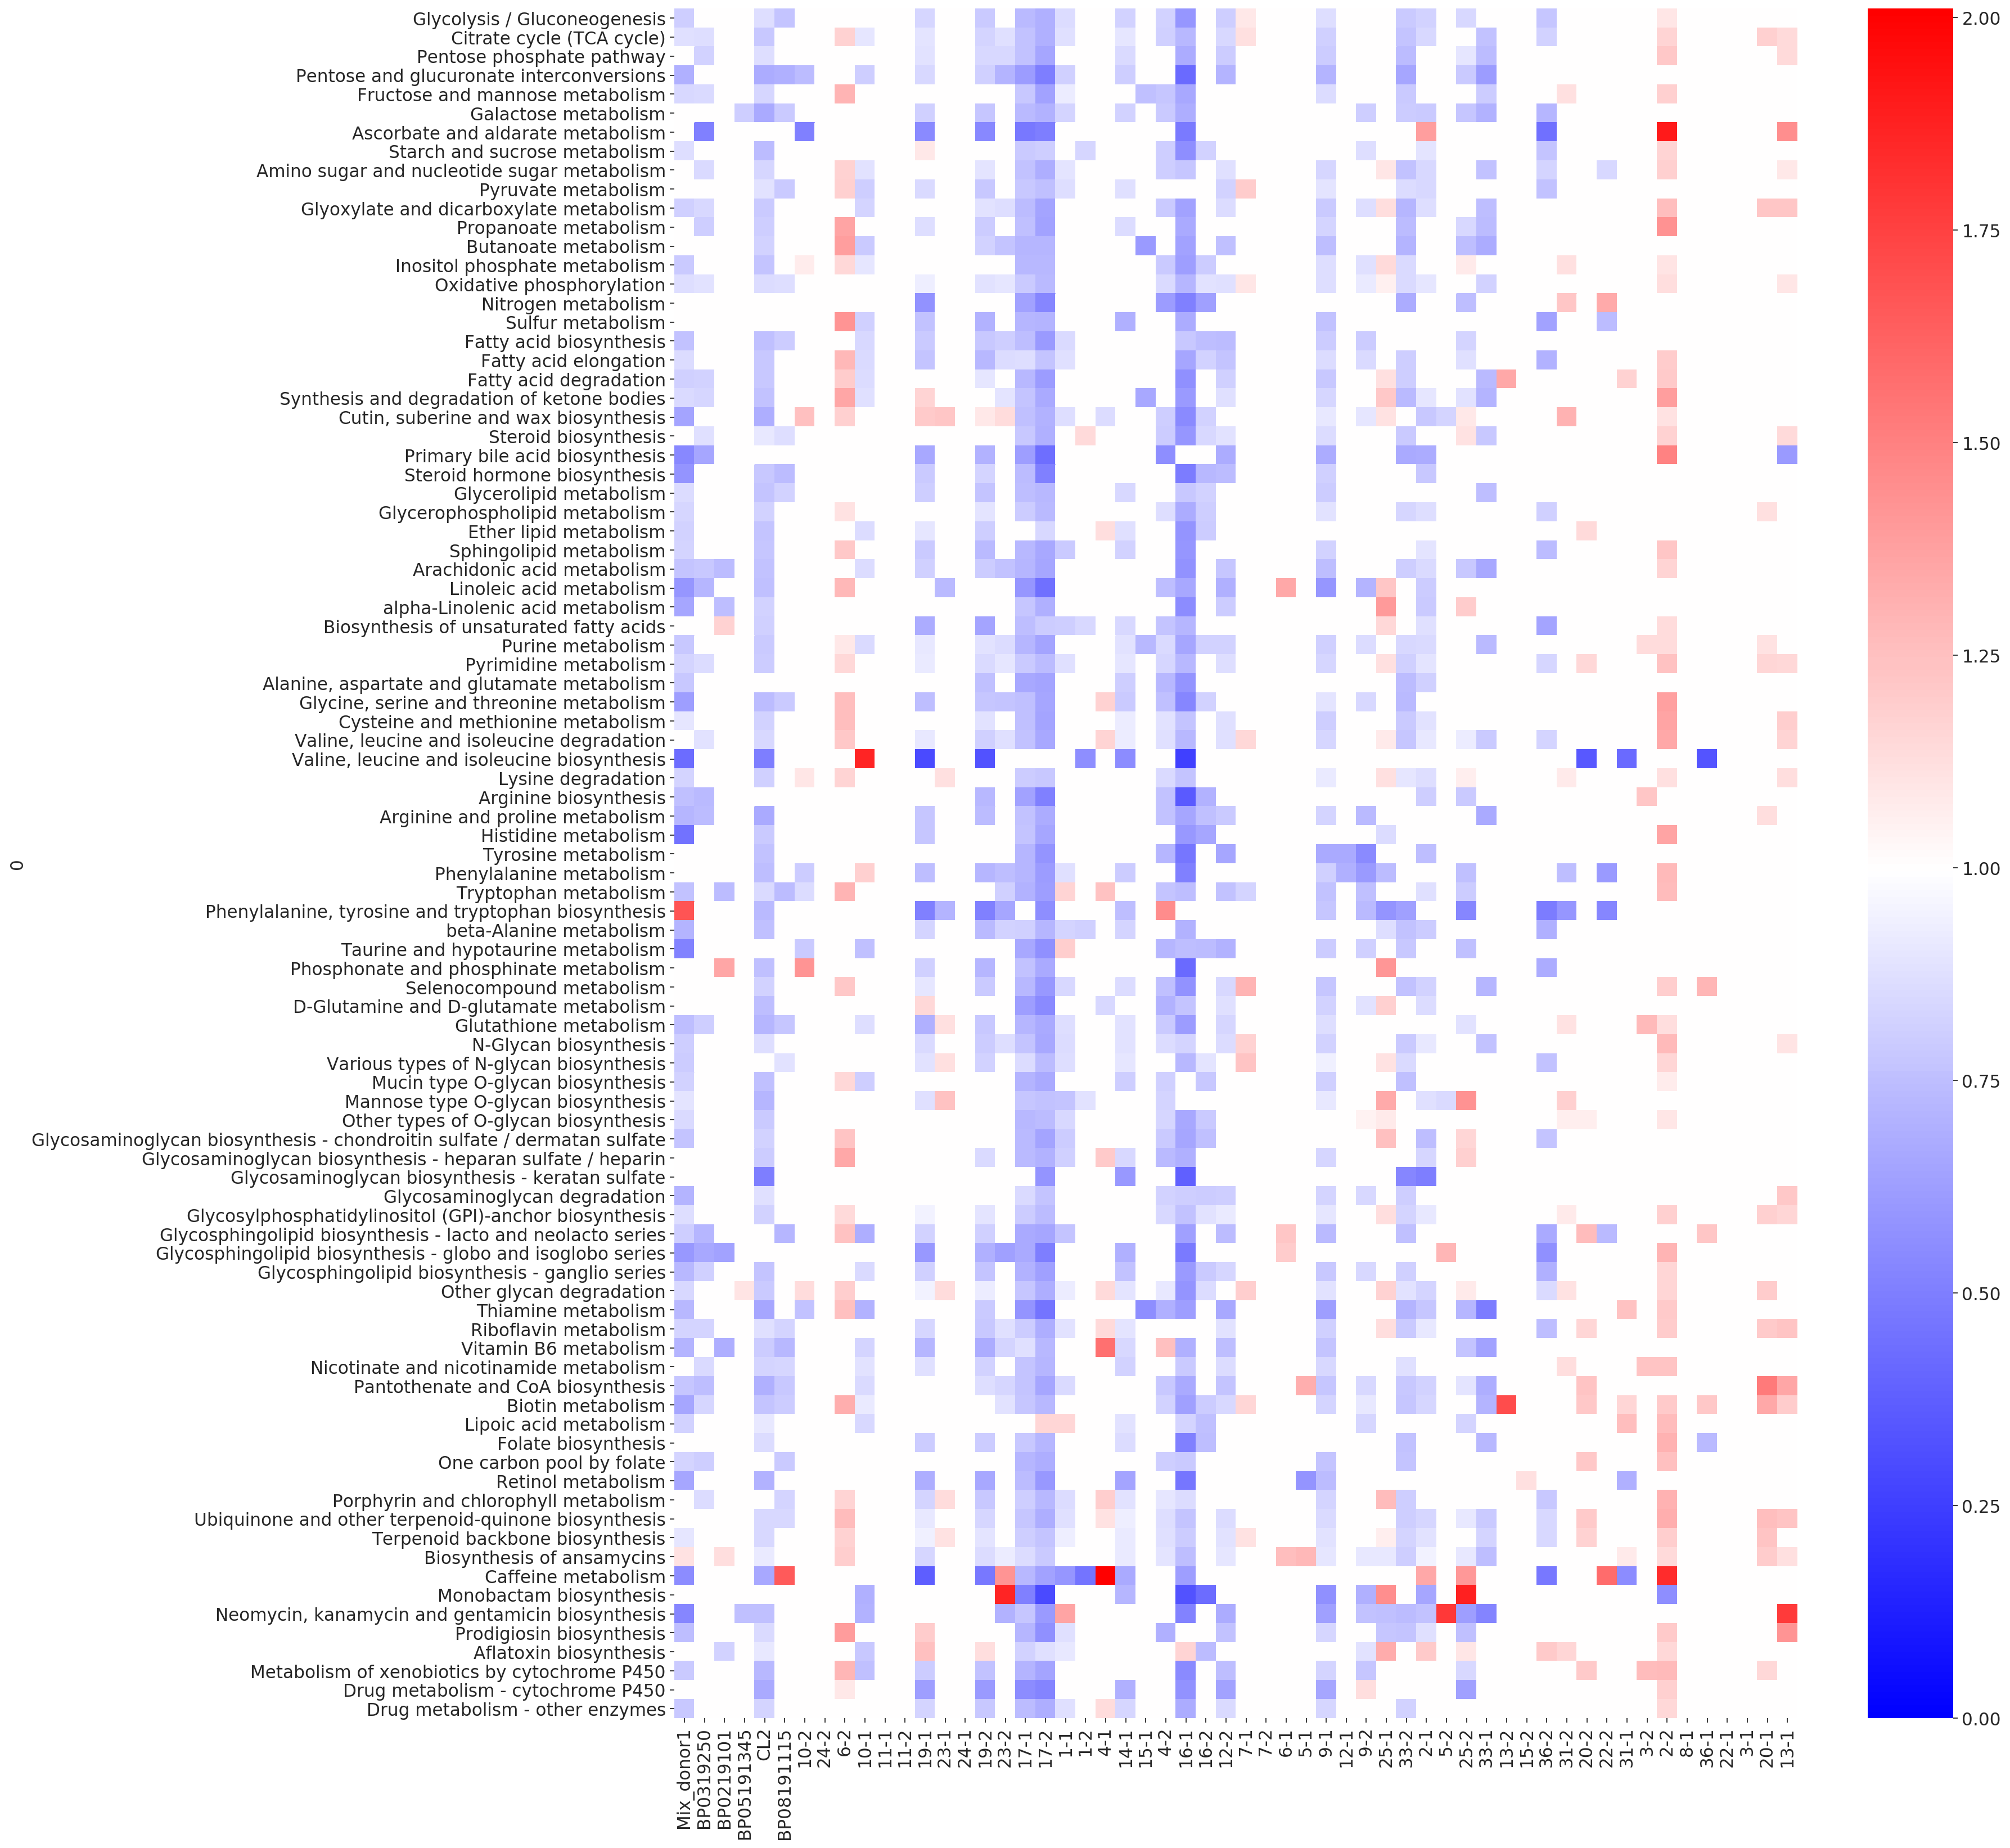

In [195]:
df_p = pd.DataFrame(p_sig)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 25))
ax = sns.heatmap(df_p, cmap='bwr', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))

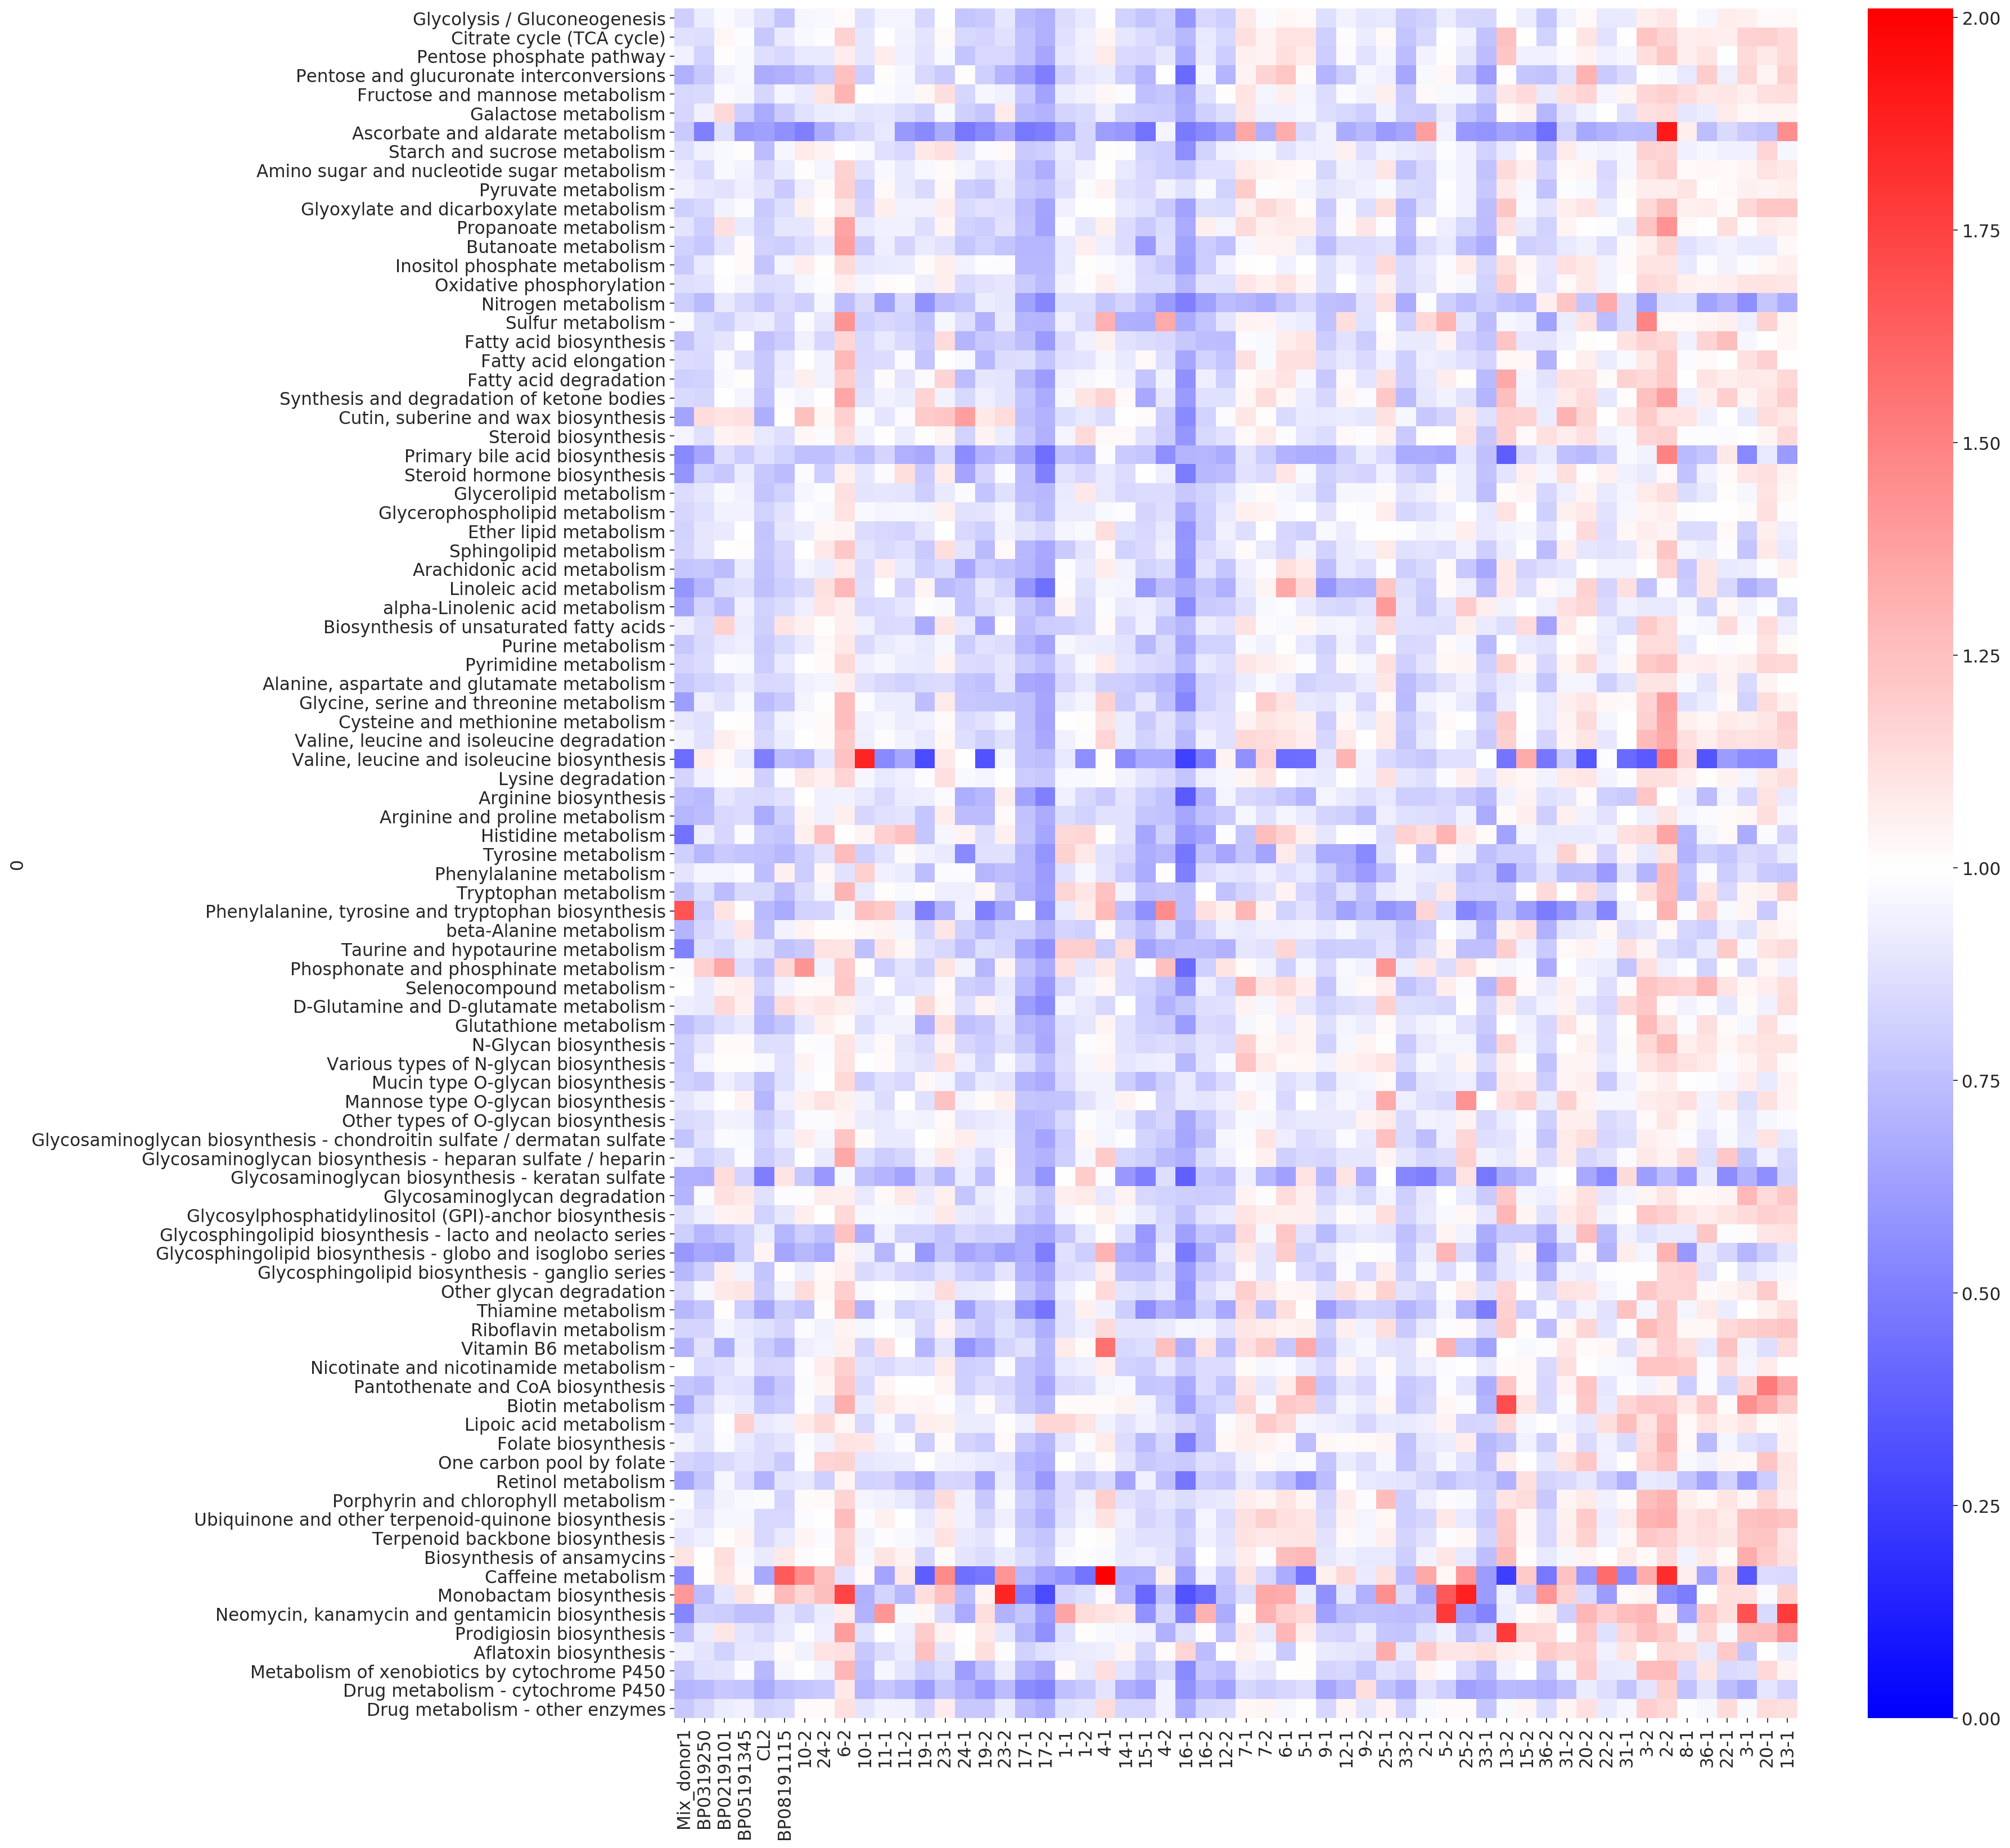

In [196]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 25))
ax = sns.heatmap(df_p, cmap='bwr', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))

In [197]:
spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[0], 
                      axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[1], 
                         axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
sig_pathways

Spearman   p-value  \
0                                                                        
Riboflavin metabolism                               0.534152  0.000022   
Glutathione metabolism                              0.525940  0.000031   
Fatty acid biosynthesis                             0.520026  0.000040   
Pyrimidine metabolism                               0.488050  0.000136   
Drug metabolism - other enzymes                     0.468601  0.000270   
Arginine and proline metabolism                     0.462686  0.000330   
Nicotinate and nicotinamide metabolism              0.459276  0.000370   
Pentose phosphate pathway                           0.456284  0.000409   
Fructose and mannose metabolism                     0.453813  0.000443   
Fatty acid degradation                              0.453326  0.000450   
Oxidative phosphorylation                           0.451760  0.000474   
Biotin metabolism                                   0.447272  0.000548   
Glycosylphosphatidylinositol (GPI)-anchor biosy...  0.444349  0.000602   
Purine metabolism                                   0.439583  0.000700   
Glyoxylate and dicarboxylate metabolism             0.434120  0.000829   
One carbon pool by folate                           0.433737  0.000839   
Cysteine and methionine metabolism                  0.426605  0.001043   
Ubiquinone and other terpenoid-quinone biosynth...  0.422464  0.001181   
Terpenoid backbone biosynthesis                     0.414566  0.001490   
Steroid hormone biosynthesis                        0.411087  0.001648   
Pyruvate metabolism                                 0.409382  0.001730   
N-Glycan biosynthesis                               0.408477  0.001776   
Glycerophospholipid metabolism                      0.406981  0.001853   
Citrate cycle (TCA cycle)                           0.403884  0.002023   
Vitamin B6 metabolism                               0.398874  0.002326   
Glycosphingolipid biosynthesis - lacto and neol...  0.397830  0.002395   
Fatty acid elongation                               0.388297  0.003104   
Porphyrin and chlorophyll metabolism                0.379877  0.003880   
Aflatoxin biosynthesis                              0.376745  0.004210   
Mucin type O-glycan biosynthesis                    0.376258  0.004263   
Arachidonic acid metabolism                         0.369682  0.005045   
Valine, leucine and isoleucine degradation          0.363559  0.005884   
Amino sugar and nucleotide sugar metabolism         0.362584  0.006028   
Alanine, aspartate and glutamate metabolism         0.349954  0.008195   
Glycine, serine and threonine metabolism            0.349815  0.008222   
Pentose and glucuronate interconversions            0.349154  0.008353   
Thiamine metabolism                                 0.342508  0.009767   
Selenocompound metabolism                           0.338960  0.010604   
Synthesis and degradation of ketone bodies          0.338438  0.010733   
Ascorbate and aldarate metabolism                   0.335445  0.011494   
Glycolysis / Gluconeogenesis                        0.335411  0.011503   
Glycerolipid metabolism                             0.334436  0.011761   
Propanoate metabolism                               0.331131  0.012673   
Pantothenate and CoA biosynthesis                   0.324555  0.014670   
Prodigiosin biosynthesis                            0.321076  0.015831   
Various types of N-glycan biosynthesis              0.319858  0.016256   
Tryptophan metabolism                               0.317596  0.017071   
Sulfur metabolism                                   0.315926  0.017694   
Galactose metabolism                                0.314395  0.018283   
alpha-Linolenic acid metabolism                     0.310255  0.019959   
Mannose type O-glycan biosynthesis                  0.296546  0.026468   
Lysine degradation                                  0.294563  0.027543   
Glycosphingolipid biosynthesis - globo and isog...  0.28

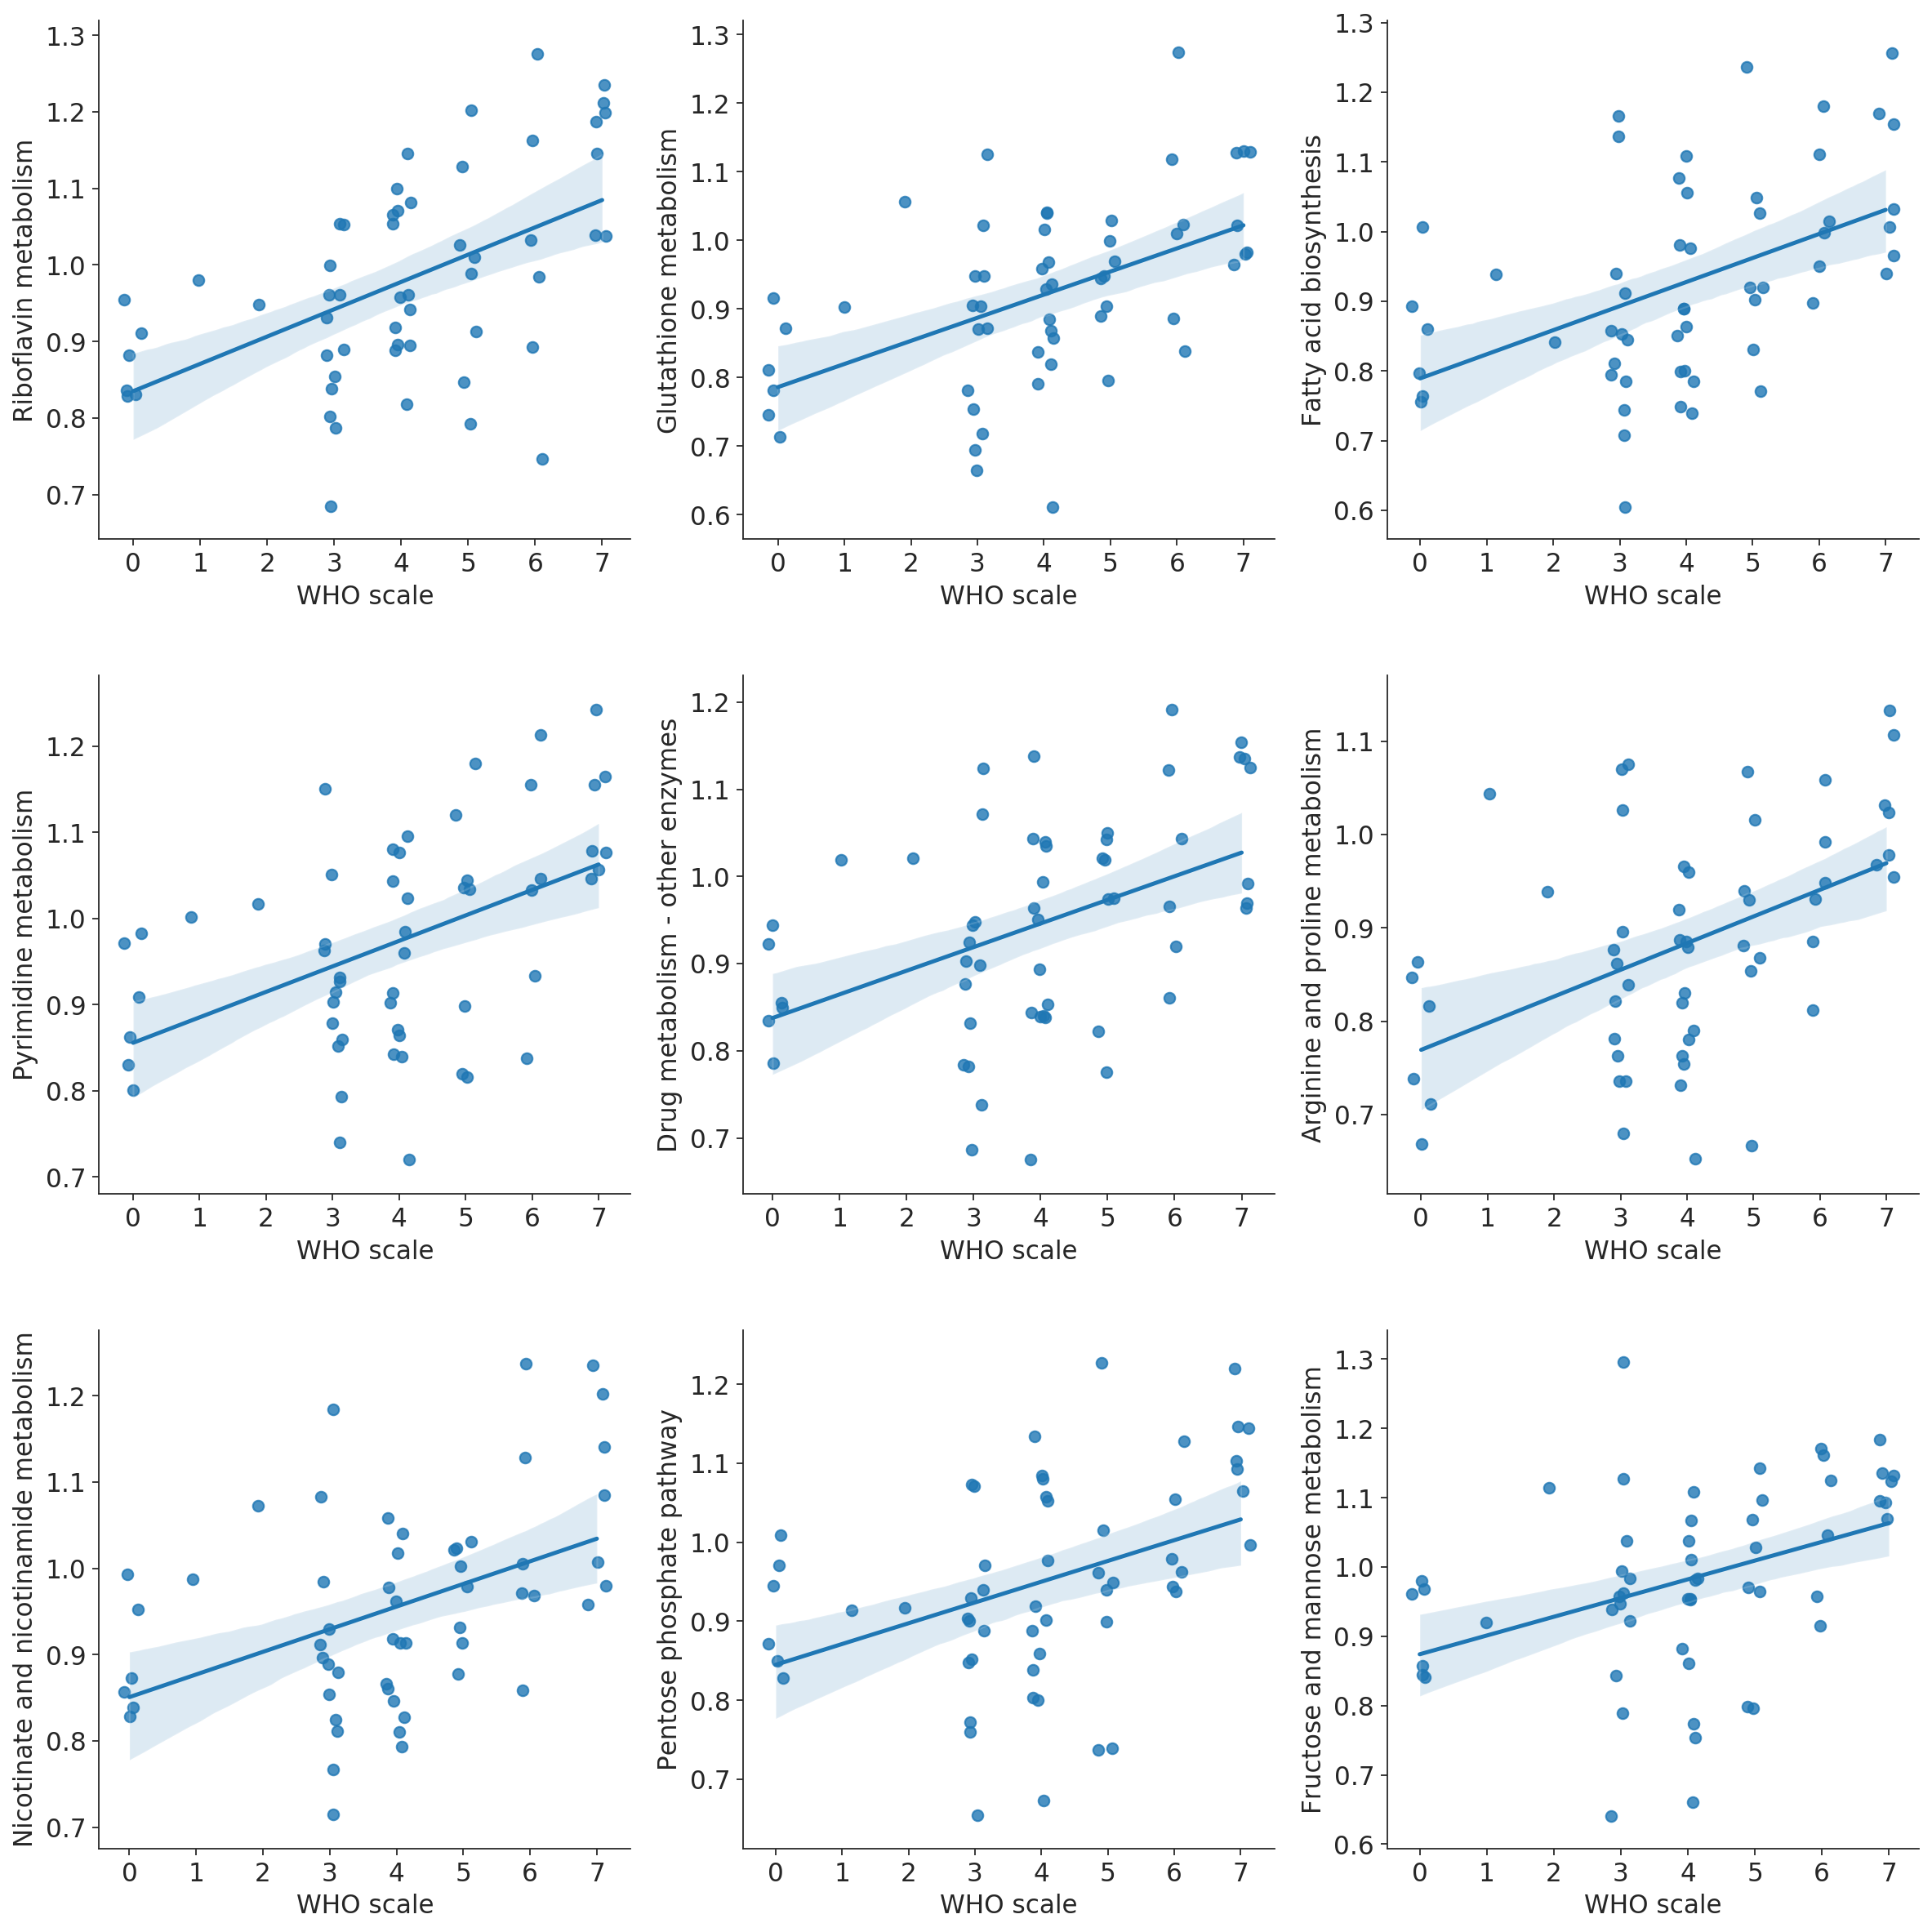

In [198]:
# Plot the top corresponding ones
sns.set_style('white')
sns.set_style('ticks')
f, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=False)
sns.despine()

k = 0
x = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
for i in range(3):
    for j in range(3):
        f = sns.regplot(x=x, y=df_p.loc[sig_pathways.index[k]], x_jitter=0.15, ax=axes[i, j])
        f.set_ylabel(sig_pathways.index[k])
        f.set_xlabel('WHO scale')
        f.set_xticks(range(8))
        k += 1

plt.tight_layout()

[Text(260.7777777777777, 0.5, '')]

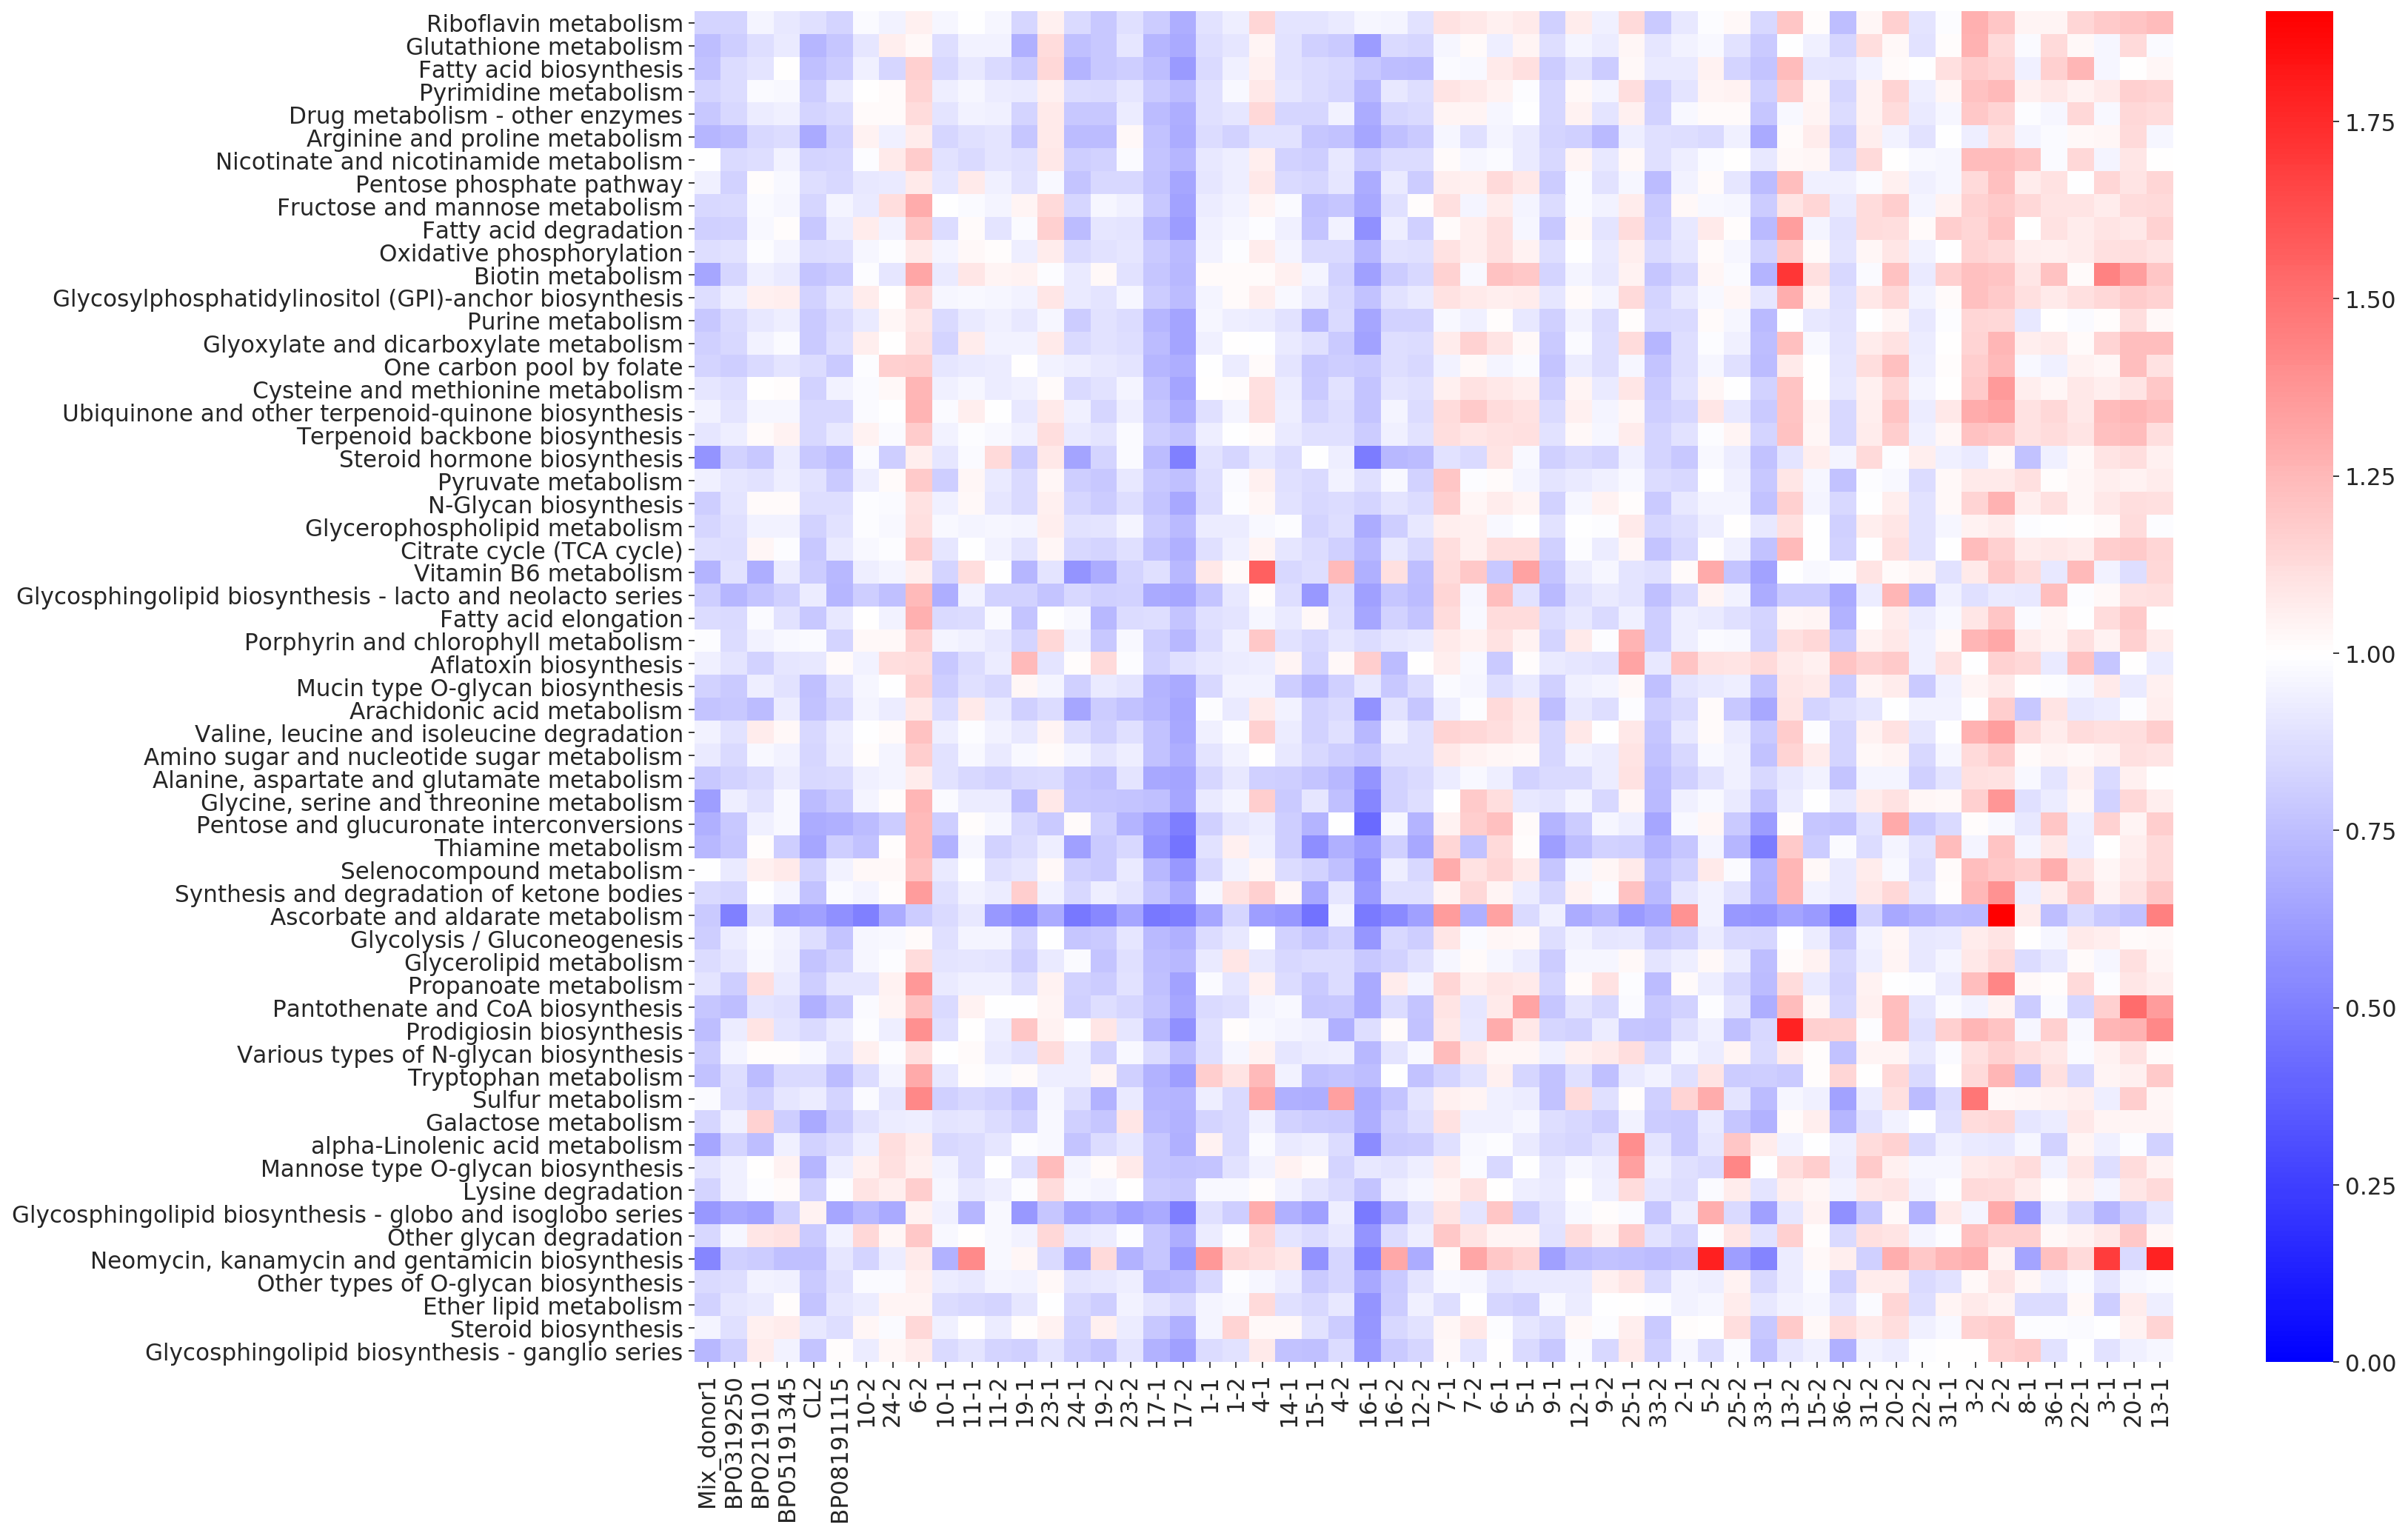

In [199]:
# Plot the top corresponding ones
df_p_corresponding = pd.DataFrame(p)
df_p_corresponding.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p_corresponding.columns = patients

patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p_corresponding = df_p_corresponding.loc[sig_pathways.index, patients_WHO]

ax = plt.figure(figsize=(20, 15))
ax = sns.heatmap(df_p_corresponding, cmap='bwr', yticklabels=sig_pathways.index, vmin=0,
                     norm=DivergingNorm(1.0))
ax.set(ylabel='')